Elisa Degara 3176276, Benedetta Zanini 3148772

# Simulations in 3d Ising model

The aim of our project is to study the behaviour of $N^3$ interacting spins in a 3 dimensional lattice (3D Ising model) using the Metropolis-Hastings algorithm.

Specifically, we are interested in finding the critical temperature at which the spin system shifts from non-magnetized to magnetized. \
Focusing on the scenario of $J > 0$ (i.e. ferromagnetism), we first study the sampling process and the phase transition in the case of $N = 20$. We then extend the same analysis for different values of $N$.

### 0. Initial Set up

In [2]:
# importing the packages

import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure

We start by writing a function that creates three 3-dimensional lattices. We have chosen to create three different kind of lattices:
- lattice_n has around 75% of its particles with negative spin value
- lattice_p has around 75% positive spins
- lattice_b has around 50% positive spins

In [3]:
# defining initial lattices 

def init_lattices(N):
    
    # negative lattice
    init_random = np.random.random((N, N, N))
    lattice_n = np.zeros((N, N, N))
    lattice_n[init_random>=0.75] = 1
    lattice_n[init_random<0.75] = -1

    # positive lattice
    init_random = np.random.random((N, N, N))
    lattice_p = np.zeros((N, N, N))
    lattice_p[init_random>=0.25] = 1
    lattice_p[init_random<0.25] = -1

    # balanced lattice
    init_random = np.random.random((N, N, N))
    lattice_b = np.zeros((N, N, N))
    lattice_b[init_random>=0.5] = 1
    lattice_b[init_random<0.5] = -1

    return lattice_n, lattice_p, lattice_b

In [4]:
# 3d grid
N = 20

In [5]:
lattice_n, lattice_p, lattice_b = init_lattices(N)

In [6]:
# check how many positive spins there are
lattice_n[lattice_n>0].sum()/N**3

0.2605

In [7]:
def plot_lattice(lattice):

    pos_idxs = np.where(lattice > 0)
    neg_idxs = np.where(lattice < 0)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(*pos_idxs, c='y', marker='o')
    ax.scatter(*neg_idxs, c='b', marker='o')

plt.show()

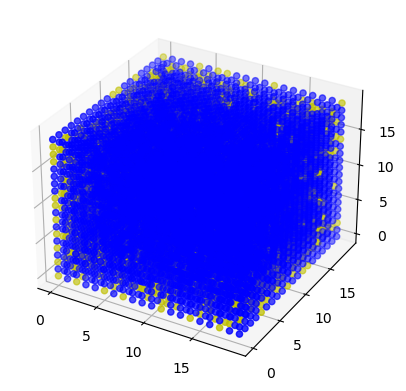

In [8]:
plot_lattice(lattice_n) # blue = negative

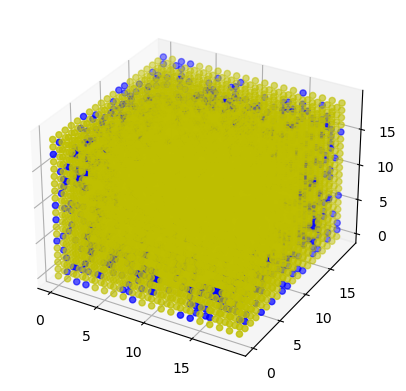

In [9]:
plot_lattice(lattice_p) # blue = negative

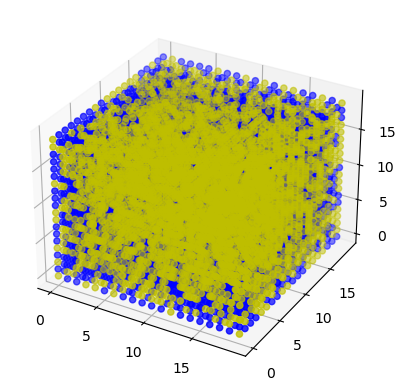

In [10]:
plot_lattice(lattice_b) # blue = negative

### 1. Energy function

We write a function to define the energy of a lattice $S$.
Ising model energy is defined as: $$ E(S) = - \frac{J}{2}\sum_{(i,j)} \sigma_i\sigma_j -B \sum_{i} \sigma_i $$
With $(i, j)$ neighbouring spins, $J$ the coupling constant and $B$ the external magnetic field.
For simplicity we will consider only the case of $B = 0$.

Boltzmann distribution gives the probability of being in a lattice configuration $S$: $$ Pr(S) = e^{-\beta E(S)} = e^{\frac{ \beta J}{2} \sum_{(i,j)} \sigma_i\sigma_j} $$

In our function, we compute energy as: $$ E(S) = - \frac{1}{2}\sum_{(i,j)} \sigma_i\sigma_j $$


In [11]:
# energy = - 0.5 * sum<i, j>(sigma_i, sigma_j)

def get_energy(lattice):

    # kern creates a grid for selecting nearest neighbours
    kern = generate_binary_structure(3, 1) 
    kern[1][1][1] = False

    # convolve = matrix of nn sums of each sigma i
    # then multiply by sigma i
    # add minus sign
    arr = -lattice * convolve(lattice, kern, mode='constant', cval=0)
    
    return arr.sum()/2

In [12]:
get_energy(lattice_n), get_energy(lattice_p), get_energy(lattice_b)

(-5130.0, -5442.0, -52.0)

In [13]:
# energy minima
get_energy(-np.ones((N, N, N)))

-22800.0

### 2 Metropolis-Hashting Algorithm

The algorithm has two functions:
1. It serves has a sampling algorithm: at each round it explores some configurations. Taking the set of all the configurations explored during Metroplis will give you an ensemble of Ising configurations, i.e. a set of Ising configurations distributed according to Boltzmann distribution.
2. Convergence to equilibrium: the last state encountered by Metropolis is the closest to the configuration obtaining energy minima, i.e. the most stable configuration.

Algorithm steps:

- current state = u, with energy E(u)
- pick a new state v, by selecting at random one lattice entry and flipping it
- if E(v) > E(u): accept v with probability P(u->v) = exp(-B(Ev-Eu)) 
- if E(v) < E(u): accept state v, P(u->v) = 1

In [14]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:,:], i8, i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, N, rounds, BJ, energy):

    spin_arr = spin_arr.copy()
    net_spins = np.zeros(rounds-1)
    net_energy = np.zeros(rounds-1)

    for t in range(0, rounds-1):
        
        # pick random spin in the lattice
        x, y, z = np.random.randint(0, N), np.random.randint(0, N), np.random.randint(0, N)
        spin_i = spin_arr[x, y, z] # initial spin
        spin_f = spin_i*-1 # proposed change
        
        # compute energy change, consider boundary conditions
        E_i = 0
        E_f = 0
        if x > 0:
            E_i += -spin_i*spin_arr[x-1, y, z]
            E_f += -spin_f*spin_arr[x-1, y, z]
        if x < N-1:
            E_i += -spin_i*spin_arr[x+1, y, z]
            E_f += -spin_f*spin_arr[x+1, y, z]
        if y > 0:
            E_i += -spin_i*spin_arr[x, y-1, z]
            E_f += -spin_f*spin_arr[x, y-1, z]
        if y < N-1:
            E_i += -spin_i*spin_arr[x, y+1, z]
            E_f += -spin_f*spin_arr[x, y+1, z]
        if z > 0:
            E_i += -spin_i*spin_arr[x, y, z-1]
            E_f += -spin_f*spin_arr[x, y, z-1]
        if z < N-1:
            E_i += -spin_i*spin_arr[x, y, z+1]
            E_f += -spin_f*spin_arr[x, y, z+1]
        
        dE = E_f-E_i

        # make a flip based on probabilities
        # if E_f > E_i, accept the move with prob exp(-BJ*dE)
        if (dE > 0) and (np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x, y, z] = spin_f
            energy += dE
        # if E_f <= E_i, accept move
        elif dE <= 0:
            spin_arr[x, y, z] = spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

c:\Users\elyel\anaconda3\lib\site-packages\numba\core\decorators.py:253: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### 3. Studying convergence time



In order to study magnetization of a 3d Ising configuration, we need to compute magnetization as the average over configurations distributed according to Boltzmann distribution. It is proved that samples drawn using Metropolis Algorithm, after a sufficient number of rounds, follow Boltzmann distirbution. \
In this section we are trying to understand how many rounds of Metropolis are needed in order to obtain samples from a Boltzmann distribution.

The number of rounds needed for convergence depend on the number $N$ of spins and on the initial configuration.
We try to understand how many rounds we need by observing the behaviour of average magnetization (over spins in one configuration) and energy.

As a first step, we fix $N = 20$, and given our focus on $J > 0$, we set $ \beta J > 0$.

We start with repeating $10^6$ rounds of the algorithm.

C:\Users\elyel\AppData\Local\Temp\ipykernel_22824\2739938115.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


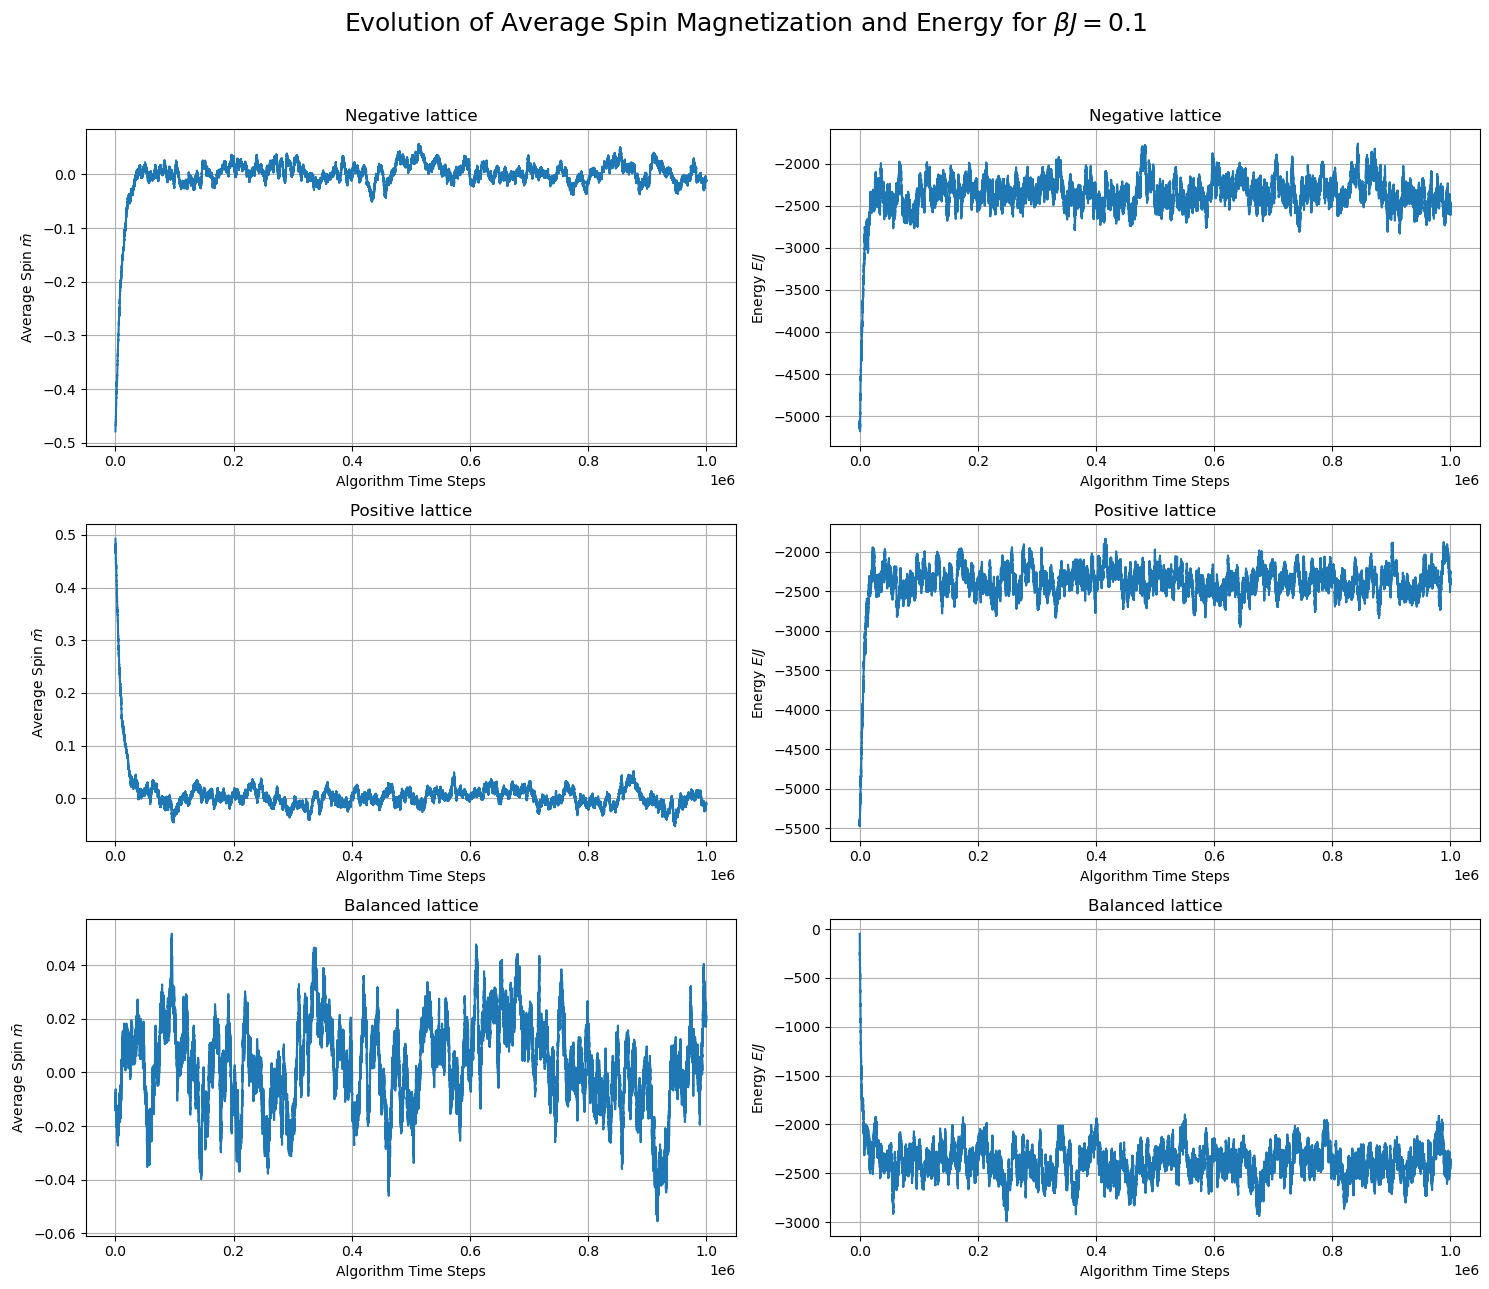

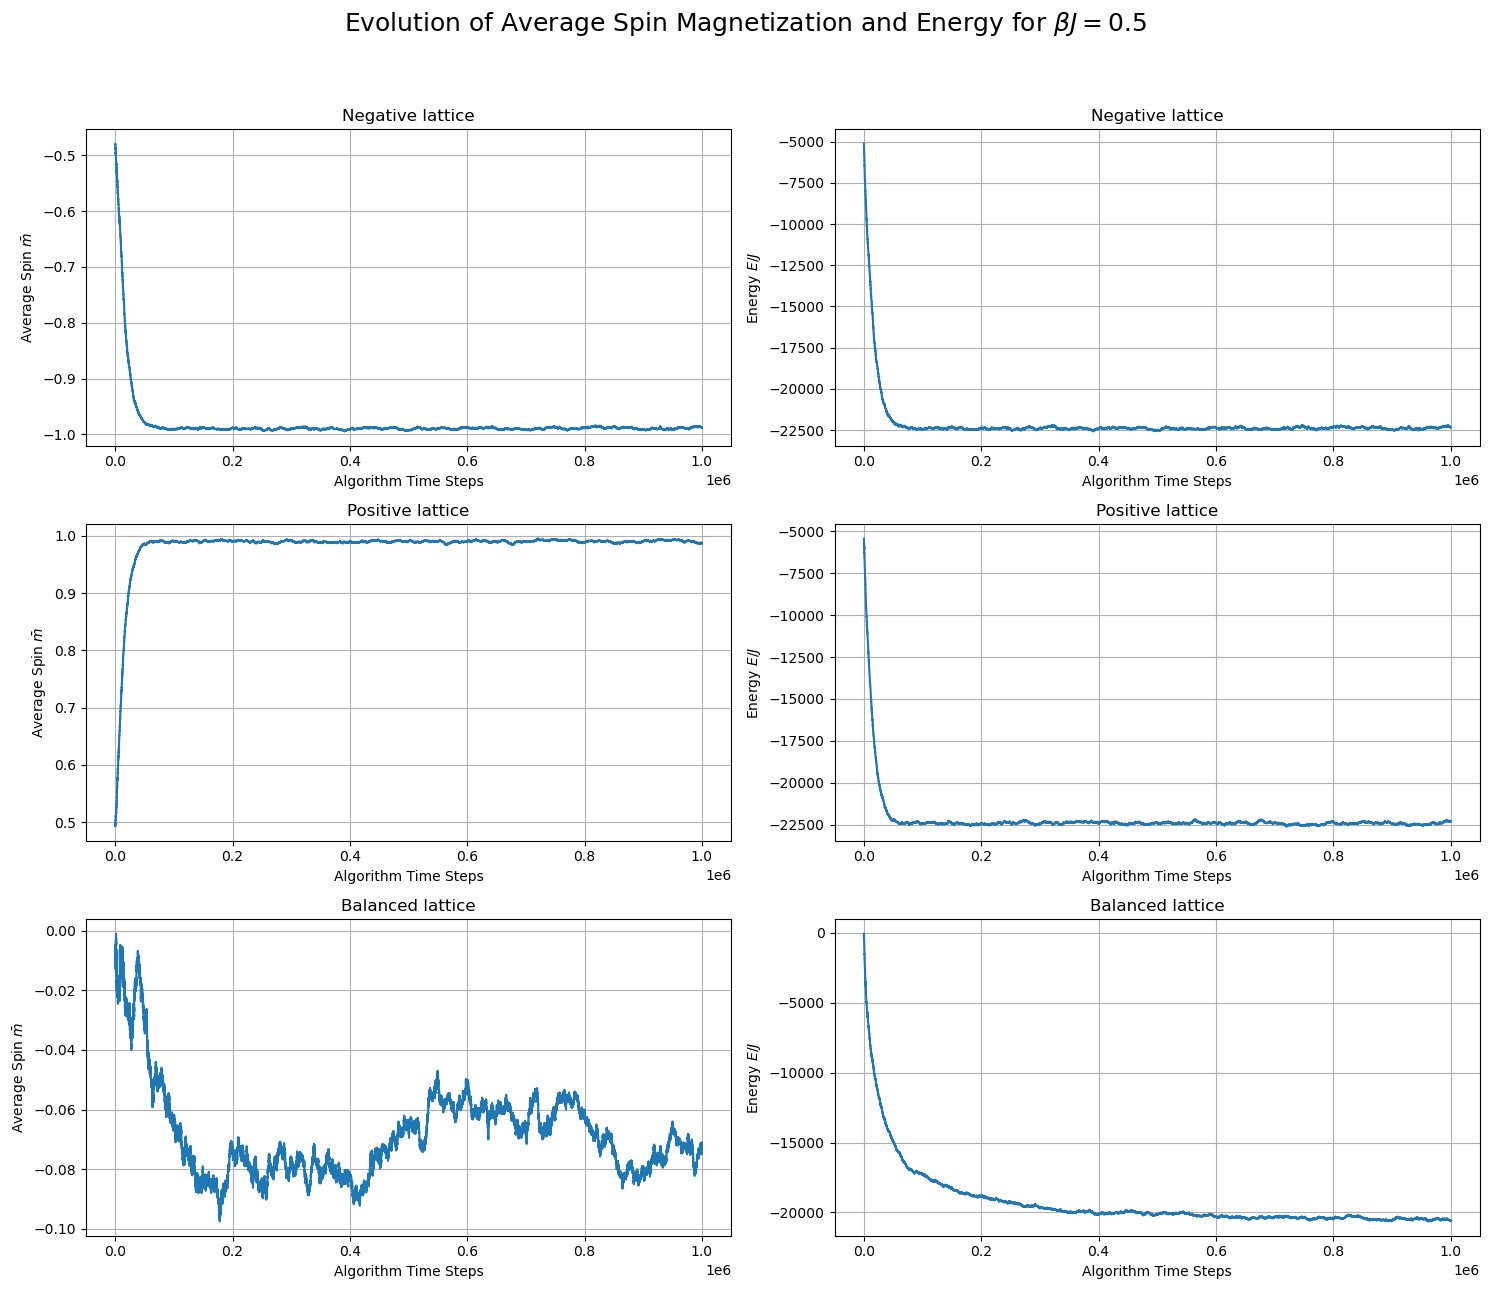

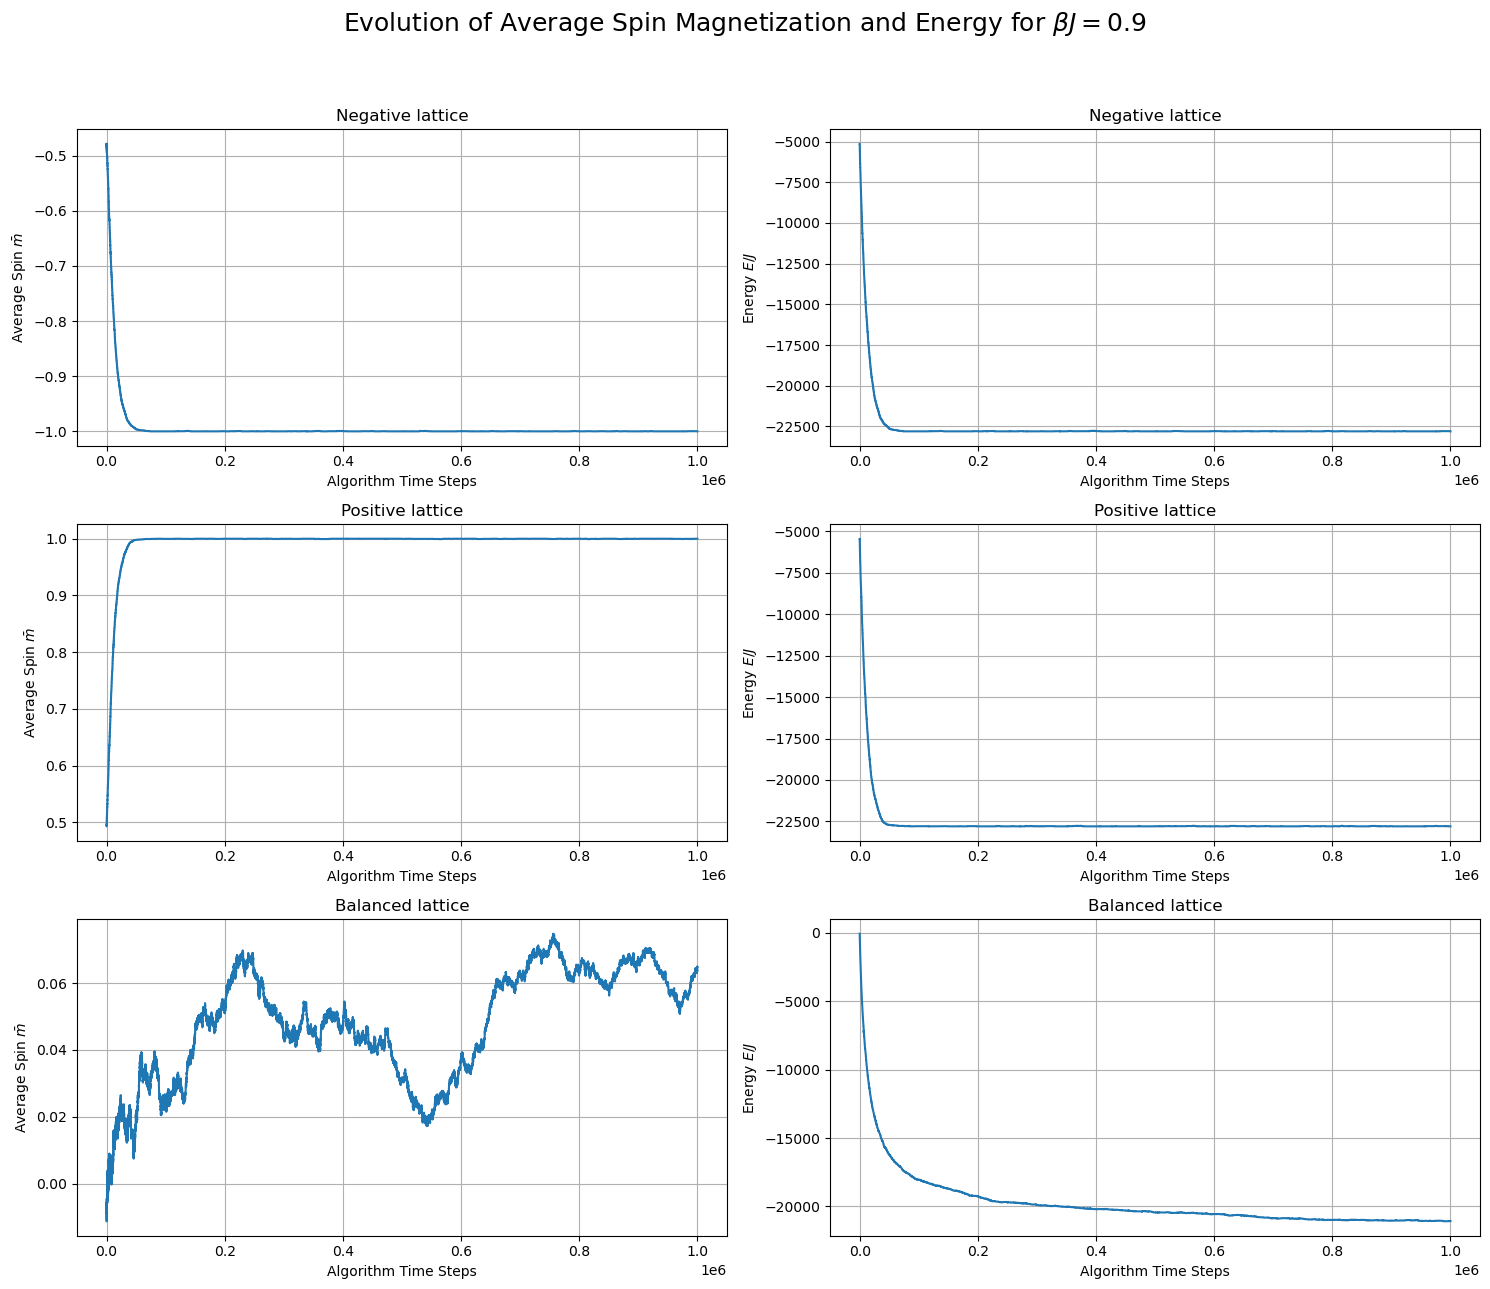

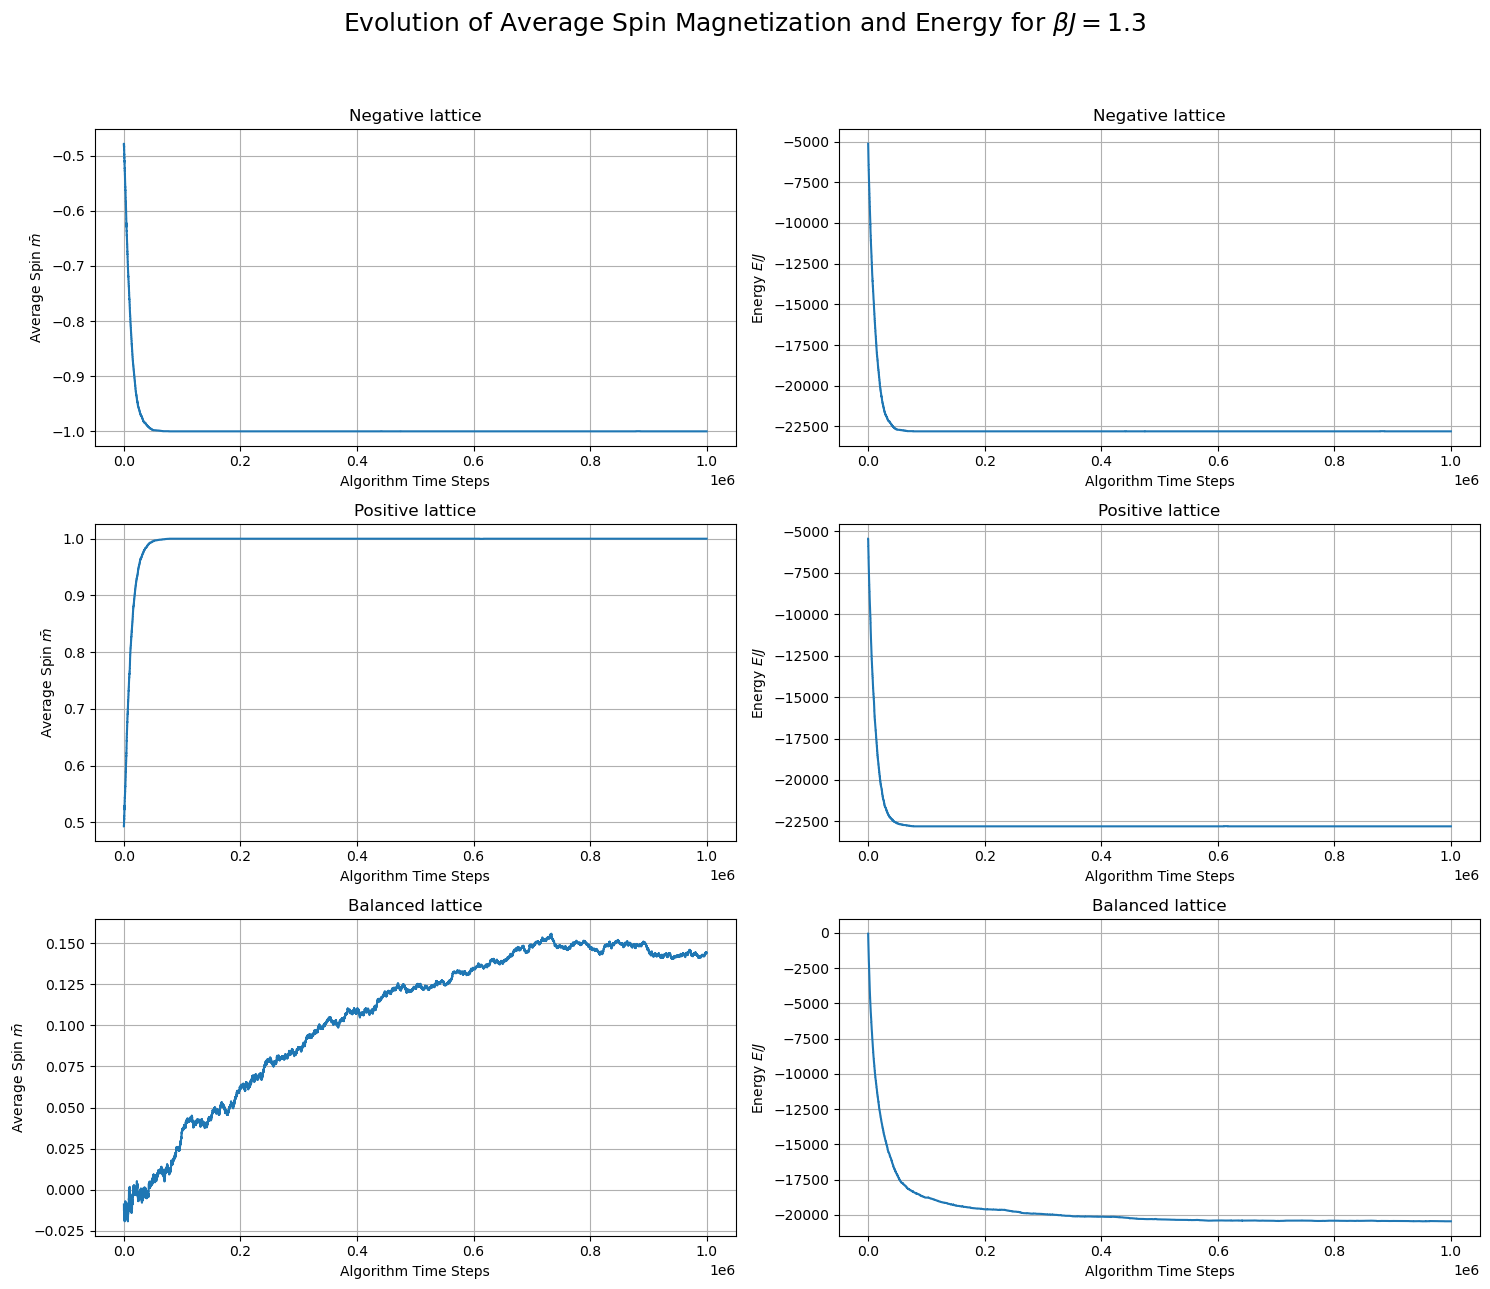

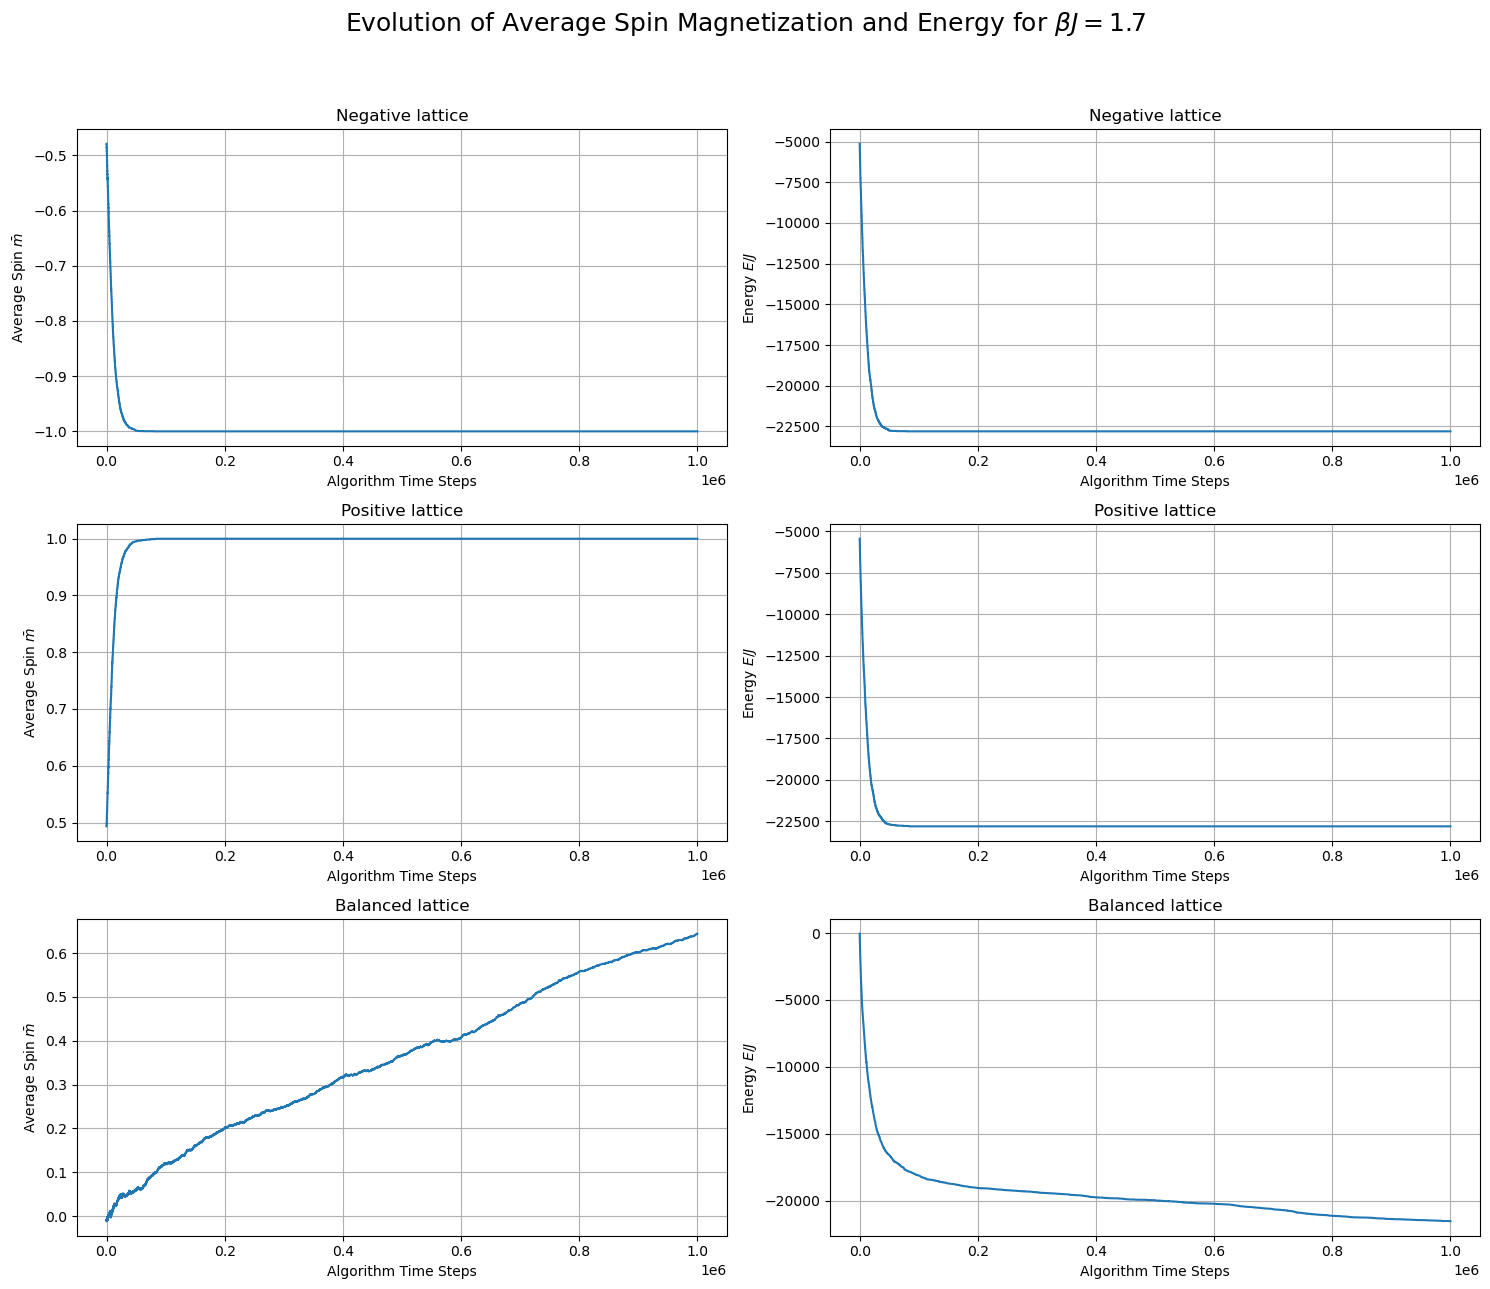

In [15]:
BJ = [0.1, 0.5, 0.9, 1.3, 1.7]

for x in BJ:
    spins_n, energies_n = metropolis(lattice_n, N, 10**6, x, get_energy(lattice_n))
    spins_p, energies_p = metropolis(lattice_p, N, 10**6, x, get_energy(lattice_p))
    spins_b, energies_b = metropolis(lattice_b, N, 10**6, x, get_energy(lattice_b))

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    ax = axes[0, 0]
    ax.plot(spins_n/N**3)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Negative lattice")
    ax.grid()
    ax = axes[0, 1]
    ax.plot(energies_n)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Negative lattice")
    ax.grid()

    ax = axes[1, 0]
    ax.plot(spins_p/N**3)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Positive lattice")
    ax.grid()
    ax = axes[1, 1]
    ax.plot(energies_p)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Positive lattice")
    ax.grid()

    ax = axes[2, 0]
    ax.plot(spins_b/N**3)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Balanced lattice")
    ax.grid()
    ax = axes[2, 1]
    ax.plot(energies_b)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Balanced lattice")
    ax.grid()

    fig.tight_layout()
    fig.suptitle(f"Evolution of Average Spin Magnetization and Energy for $\\beta J = {x}$", y=1.07, size=18)
    fig.show()

We now try to do $10^7$ repetitions.

C:\Users\elyel\AppData\Local\Temp\ipykernel_22824\4241816097.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


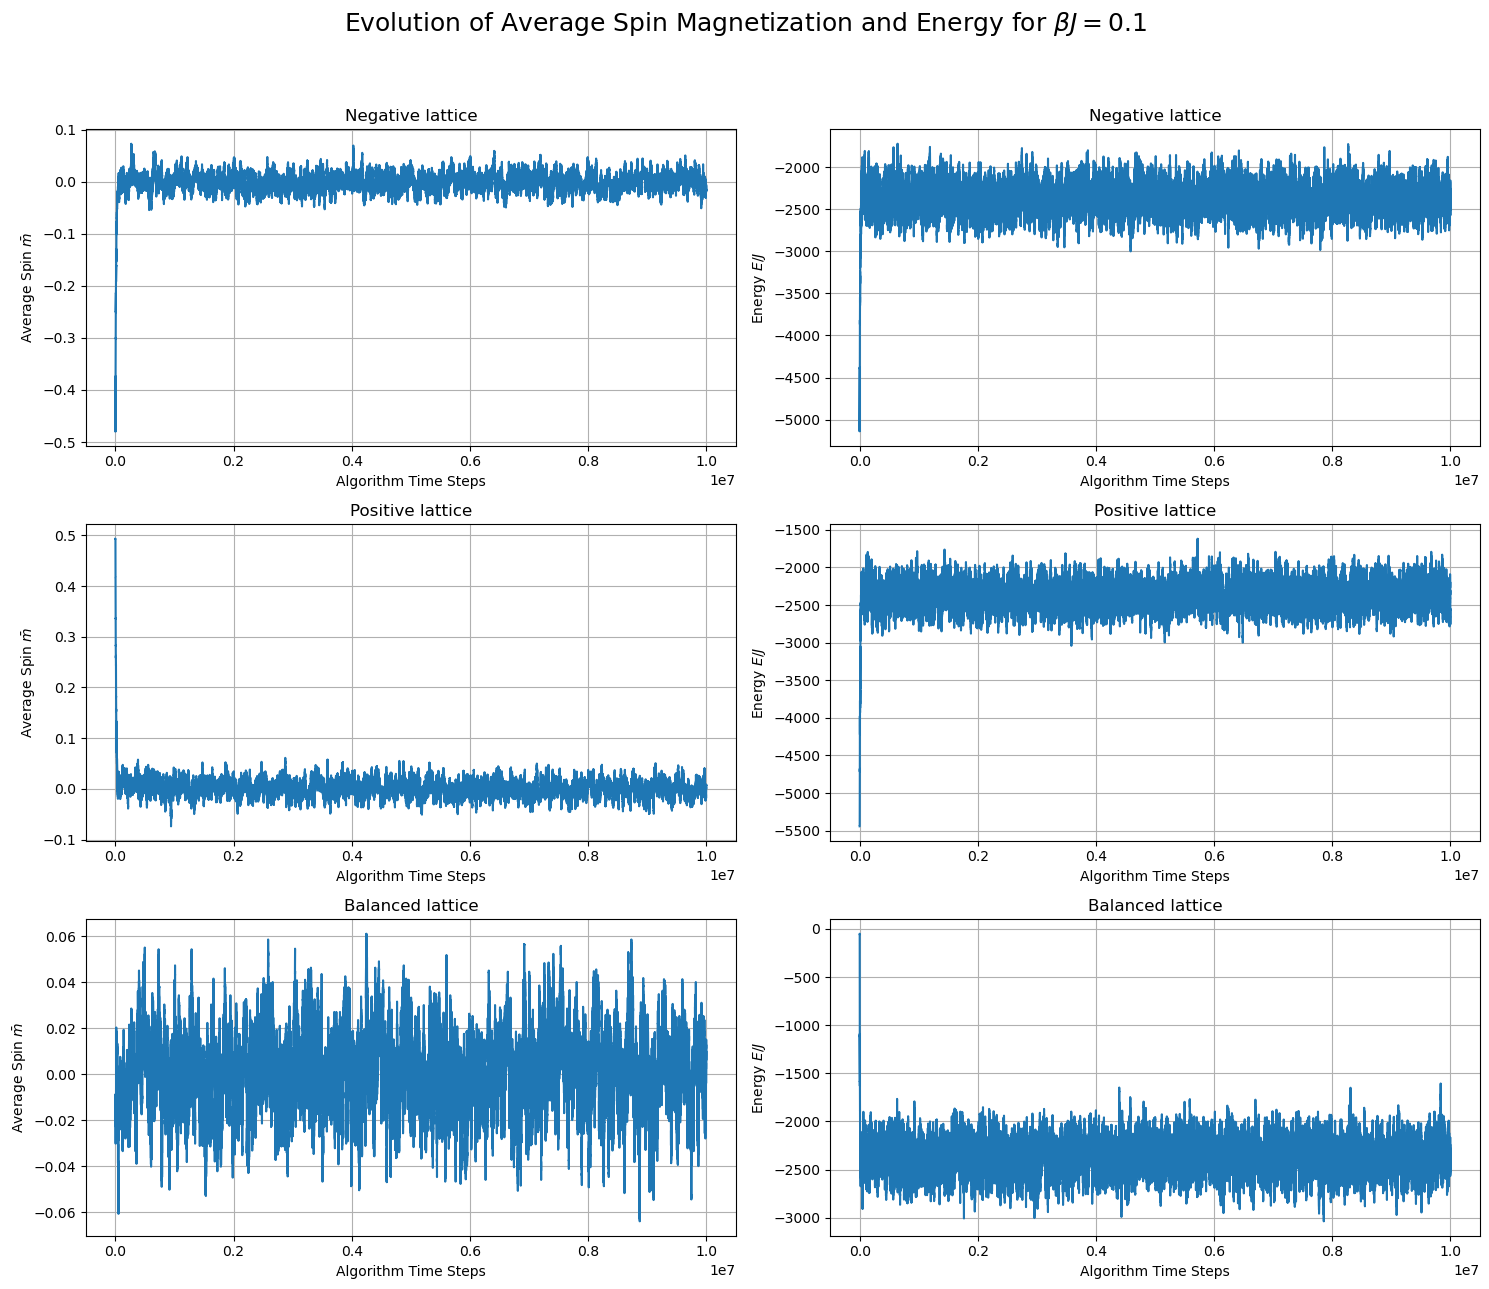

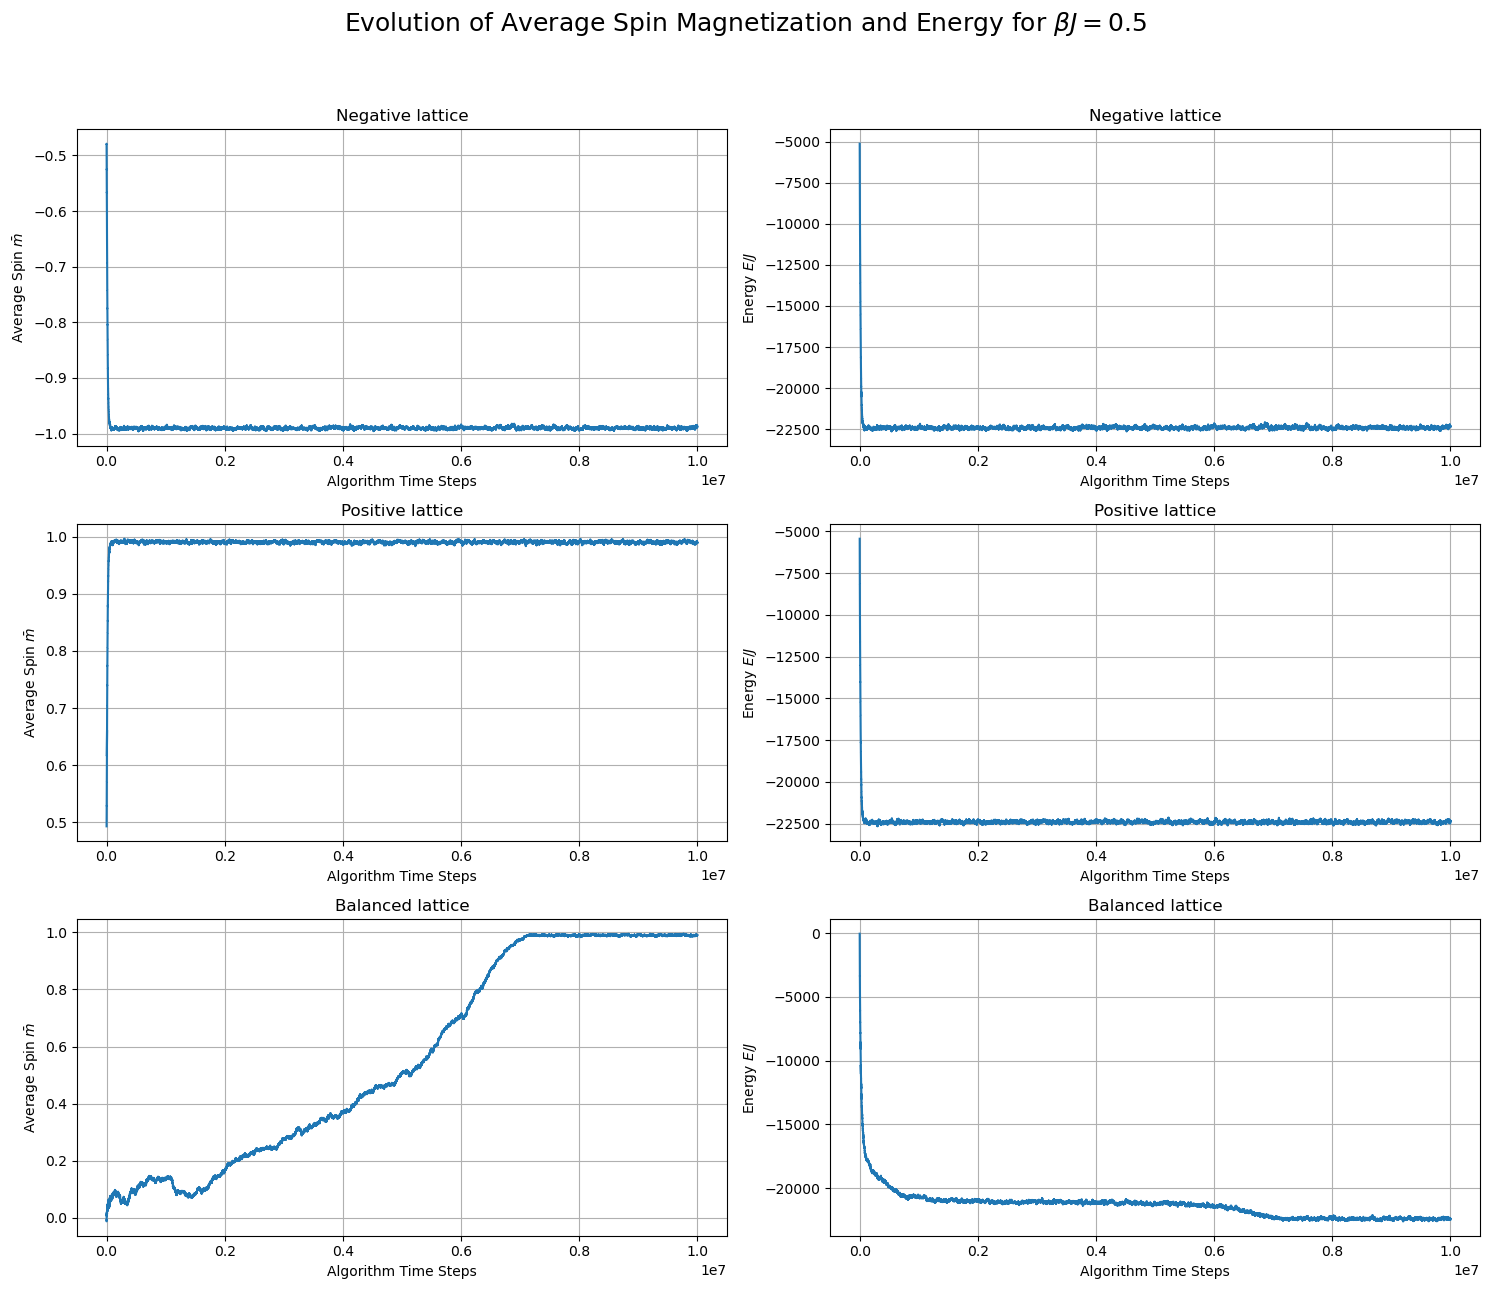

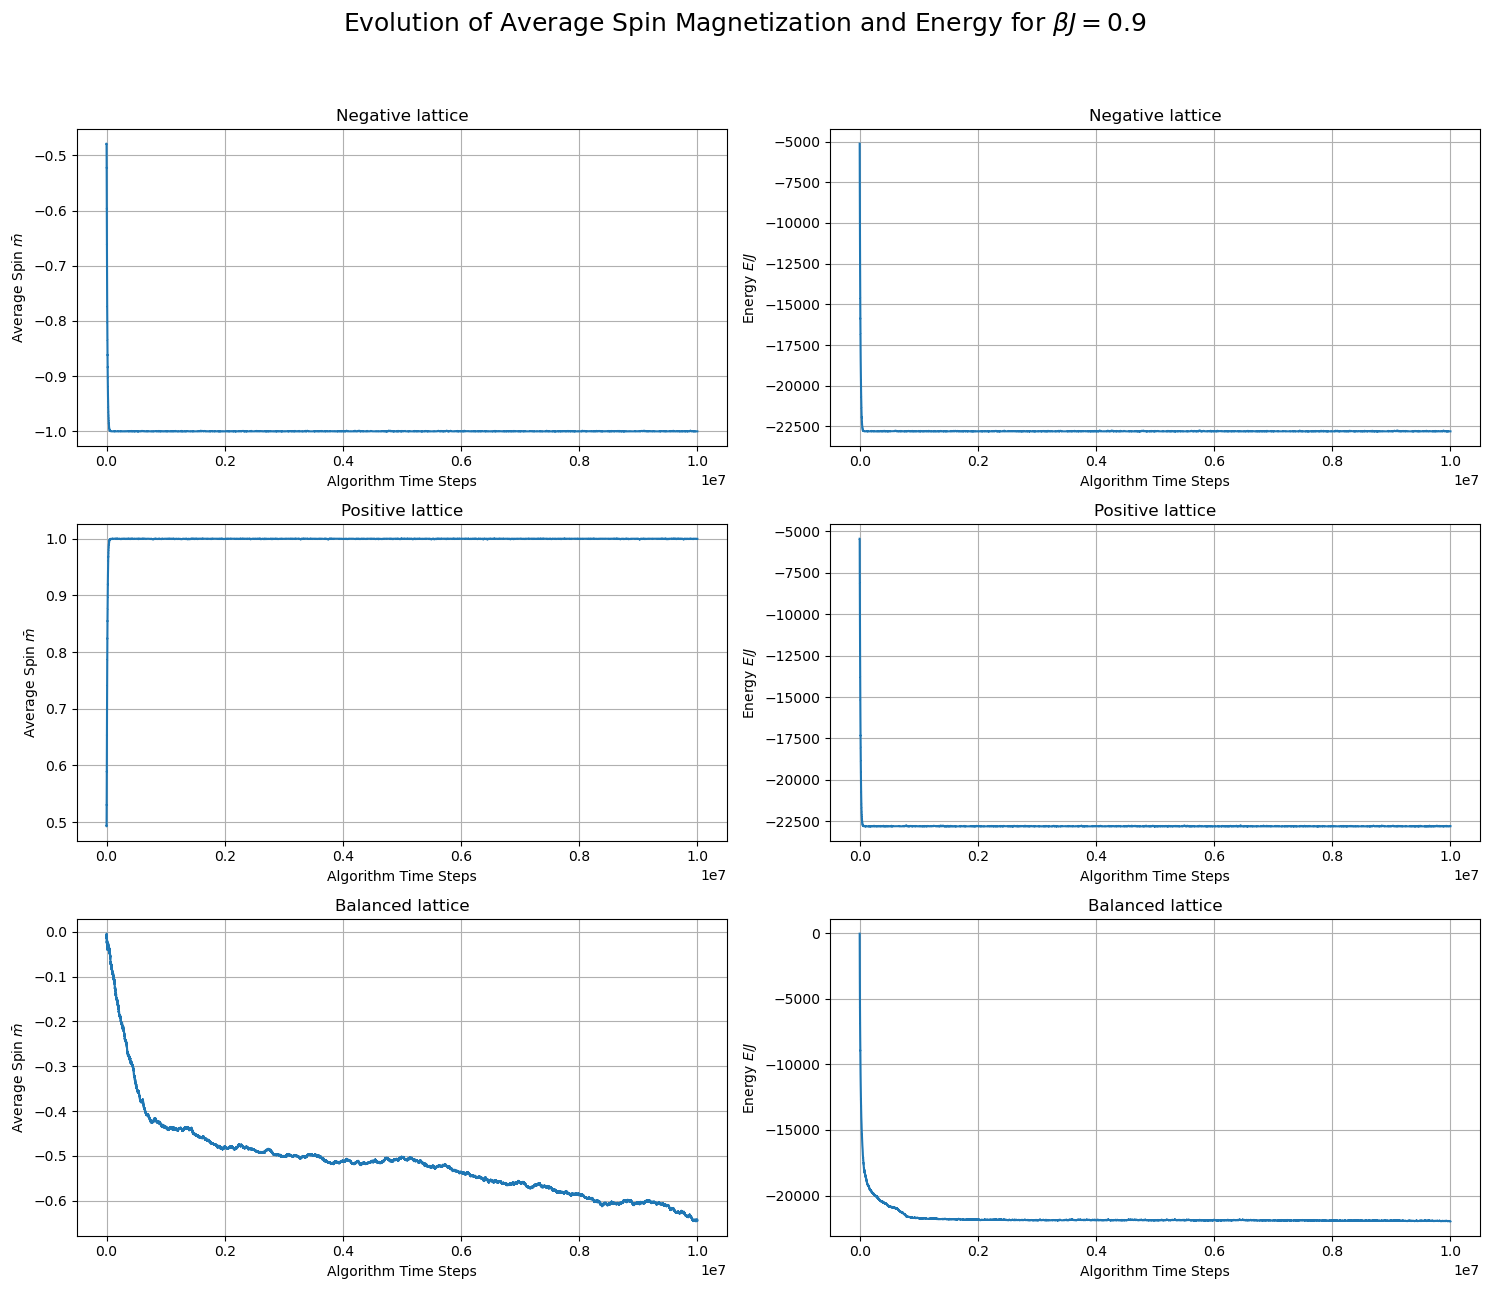

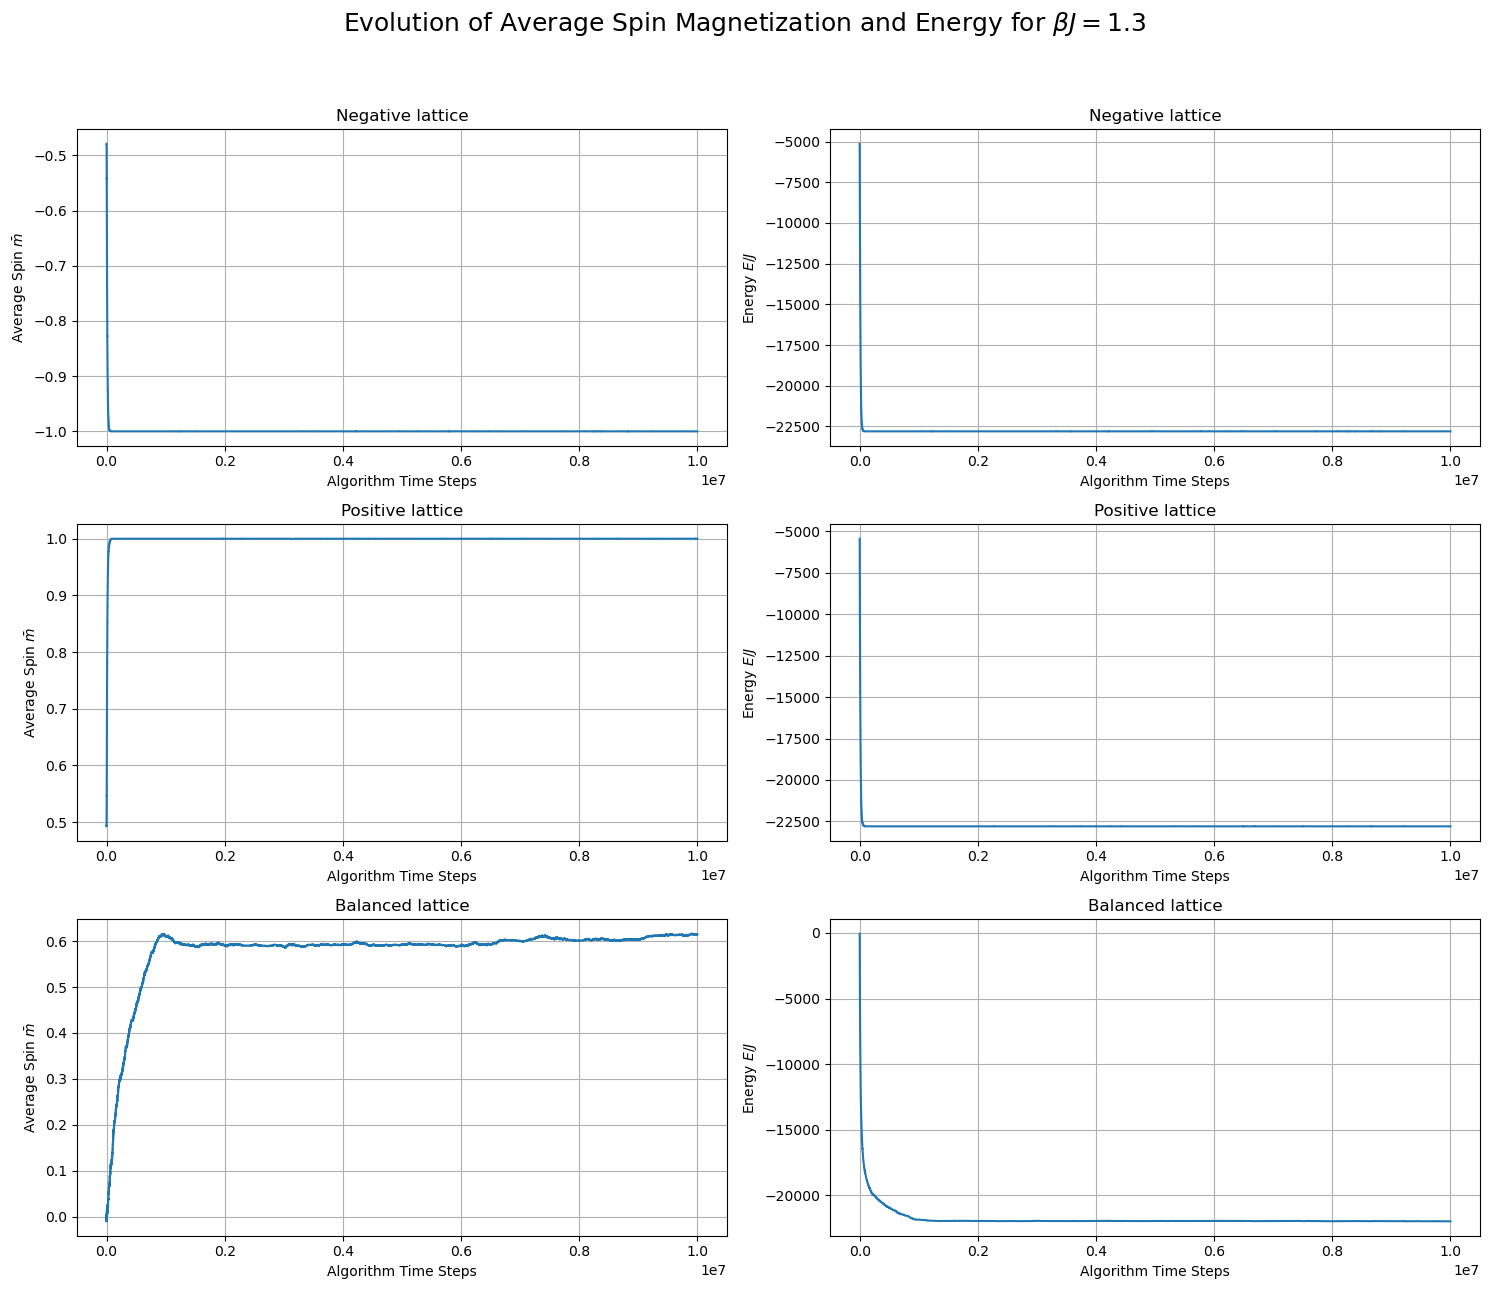

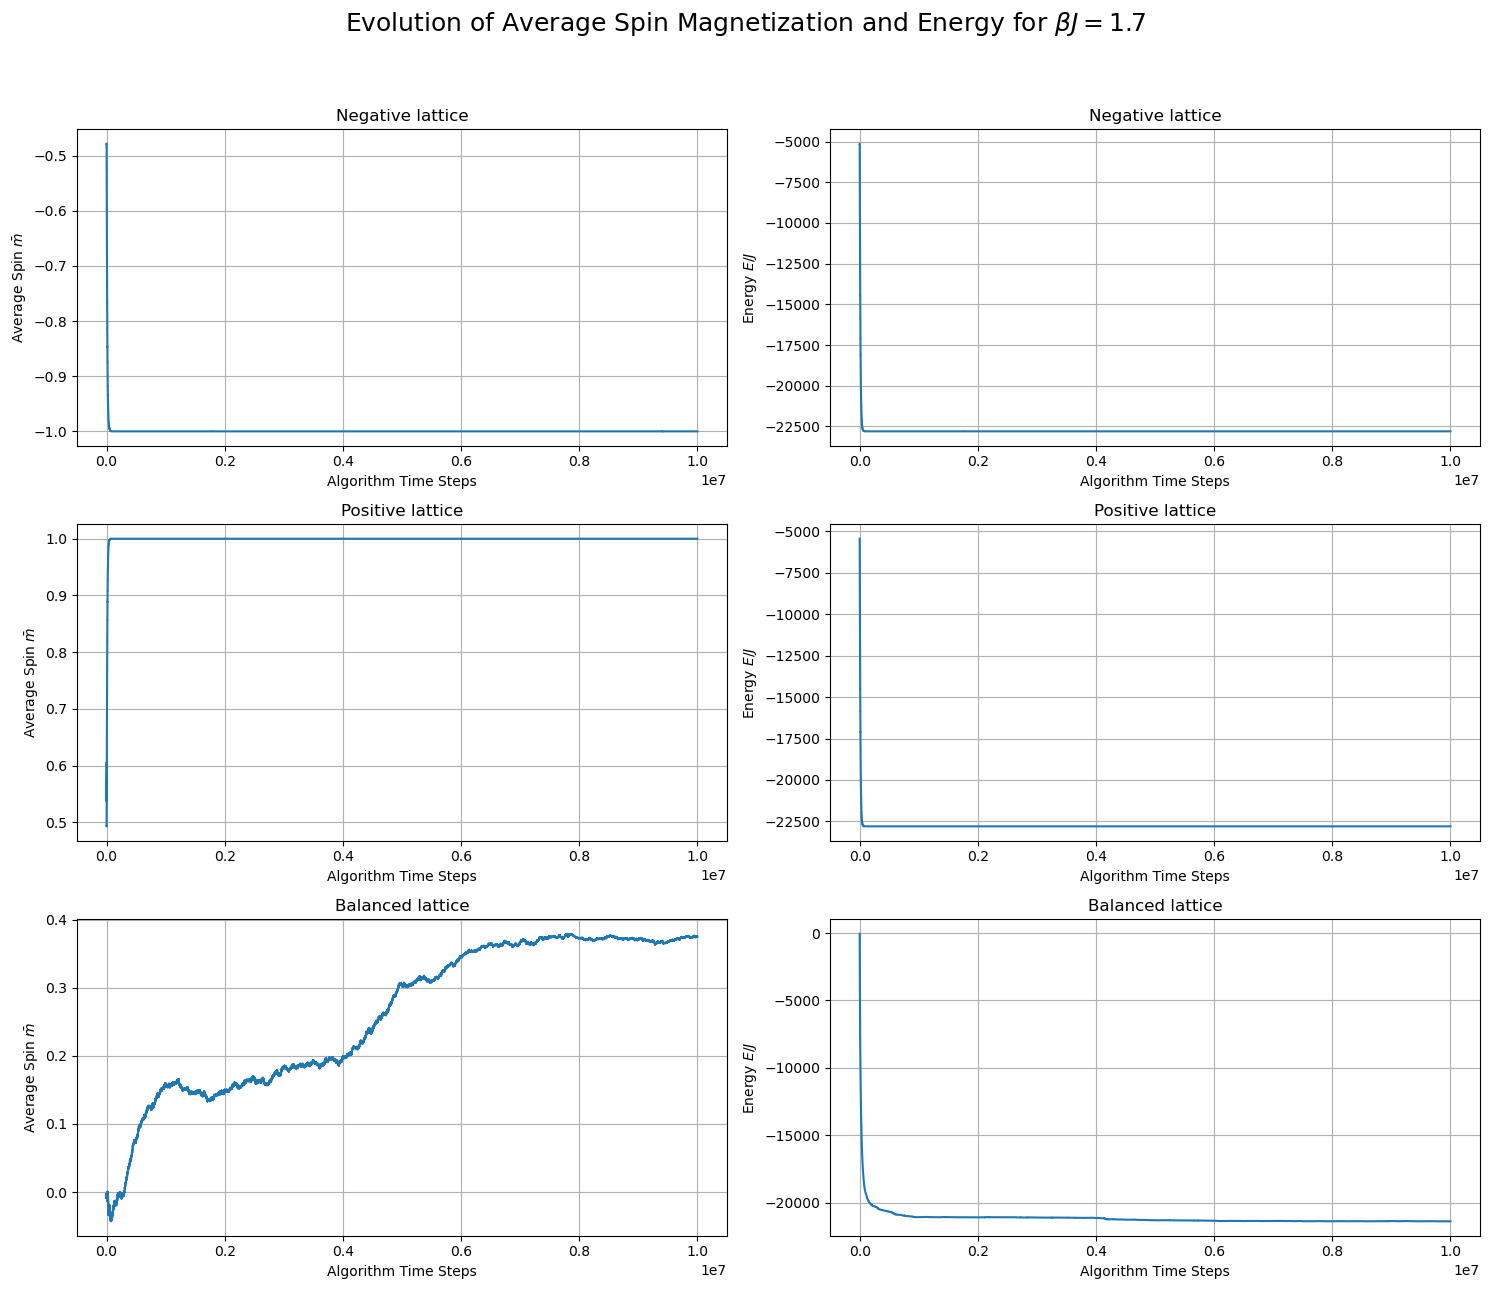

In [16]:
BJ = [0.1, 0.5, 0.9, 1.3, 1.7]

for x in BJ:
    spins_n, energies_n = metropolis(lattice_n, N, 10**7, x, get_energy(lattice_n))
    spins_p, energies_p = metropolis(lattice_p, N, 10**7, x, get_energy(lattice_p))
    spins_b, energies_b = metropolis(lattice_b, N, 10**7, x, get_energy(lattice_b))

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    ax = axes[0, 0]
    ax.plot(spins_n/N**3)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Negative lattice")
    ax.grid()
    ax = axes[0, 1]
    ax.plot(energies_n)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Negative lattice")
    ax.grid()

    ax = axes[1, 0]
    ax.plot(spins_p/N**3)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Positive lattice")
    ax.grid()
    ax = axes[1, 1]
    ax.plot(energies_p)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Positive lattice")
    ax.grid()

    ax = axes[2, 0]
    ax.plot(spins_b/N**3)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Balanced lattice")
    ax.grid()
    ax = axes[2, 1]
    ax.plot(energies_b)
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Balanced lattice")
    ax.grid()

    fig.tight_layout()
    fig.suptitle(f"Evolution of Average Spin Magnetization and Energy for $\\beta J = {x}$", y=1.07, size=18)
    fig.show()

What we can observe from the plots is that $10^6$ rounds of simulations are more than enough, for the sampling algorithm, to obtain samples form Boltzmann distribution, in the case of the negative and the positive lattice. \
For the balanced lattice, $10^6$ rounds are not enough to reach a stable configuration, $10^7$ are needed. However, using $10^6$ steps it is still possible to understand to which configuration the balanced lattice is converging within a reasonable computational time. \
We also see that for $ \beta J = 0.1$ the average magnetization in the negative and positive lattice oscillates around 0, while for $ \beta J = 0.5$ it converges to $-1$ and $1$ respectively. 

Given all the previous observations, we decide to use $10^6$ simulation rounds, and consider the last $10^5$ samples found using Metropolis, to compute average particle magnetization over samples.

### 4. Magnetization phase transition

Now we plot, the average particle magnetization over samples obtained in the last $10^5$ rounds of Metropolis simulations (of $10^6$ rounds) as a function of the temperature. 
Following the conclusions stated in the previous section, it seems natural to consider $ \beta J \in [0.1, 2] $ with bin  size = 0.05. \
Therefore we will consider $ T \frac{k}{J} \in [0.5, 10] $.

In [17]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, BJ in enumerate(BJs):
        spins, energies = metropolis(lattice, N, 10**6, BJ, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**3
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)
ms_b, E_means_b, E_stds_b = get_spin_energy(lattice_b, BJs)

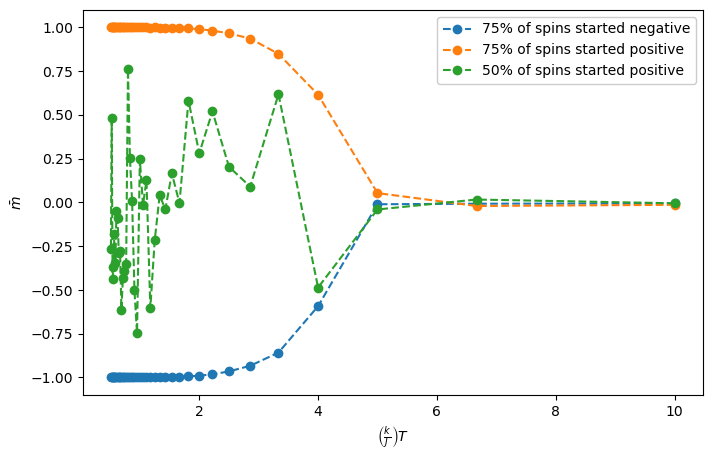

In [18]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.plot(1/BJs, ms_b[:], 'o--', label='50% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [ ]:
critical_idx = max(np.where(abs(ms_n) < 0.025)[0])
critical_BJ = BJs[critical_idx]
critical_T = critical_BJ**(-1)
critical_BJ, critical_T

(0.19999999999999998, 5.0)

When temperature $ T \frac{k}{J} $ < 5, i.e. $ \beta J > \frac{1}{5} $, the lattice is magnetized and behaves as a ferromagnet. \
When temperature $ T \frac{k}{J} > 5$, i.e. $ \beta J < \frac{1}{5} $, the lattice magnetization stays close to 0, therefore we observe the paramagnetic phase.


In the ferromagnetic phase, negative lattice and positive lattice have magnetization -1 and 1 respectively, as we would expect. \
However, the magnetization of a balanced lattice can evolve towards either 1 or -1. Each time we run the Metropolis algorithm, the evolution of the balanced lattice is randomly directed towards either the negative or positive magnetization. Consequently, in our plot we see that for different values of temperature - corresponding to different runs of the Metropolis algorithm - the magnetization in the balanced lattice oscillates between 1 and -1.

We plot the evolution of energy as a function of temperature.

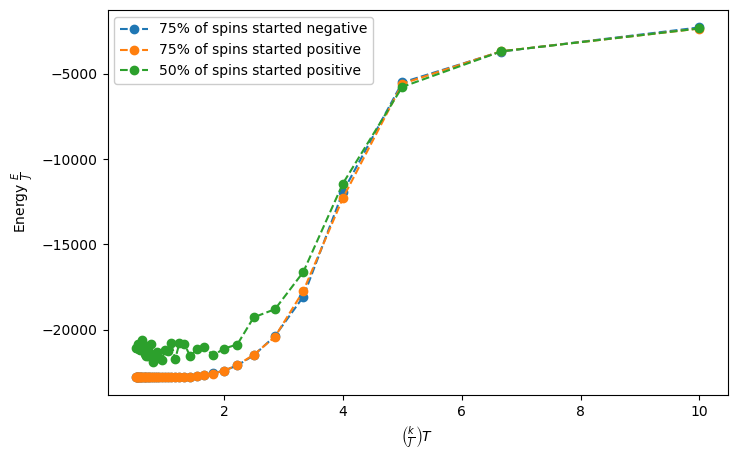

In [20]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, E_means_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, E_means_p, 'o--', label='75% of spins started positive')
plt.plot(1/BJs, E_means_b, 'o--', label='50% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'Energy $ \frac{E}{J}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

As expected, during the ferromagnetic phase, the system reaches the configuration that minimizes energy. \
In contrast, during the paramagnetic phase, the system no longer minimizes energy. High temperature reduces the effectiveness of the coupling factor $J$.

### 5. Extending results to lattices with $ N \neq 20 $

We start by considering the case of $N$ = 12.

In [40]:
N = 12

In [41]:
lattice_n, lattice_p, lattice_b = init_lattices(N)

C:\Users\elyel\AppData\Local\Temp\ipykernel_22824\1640614249.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


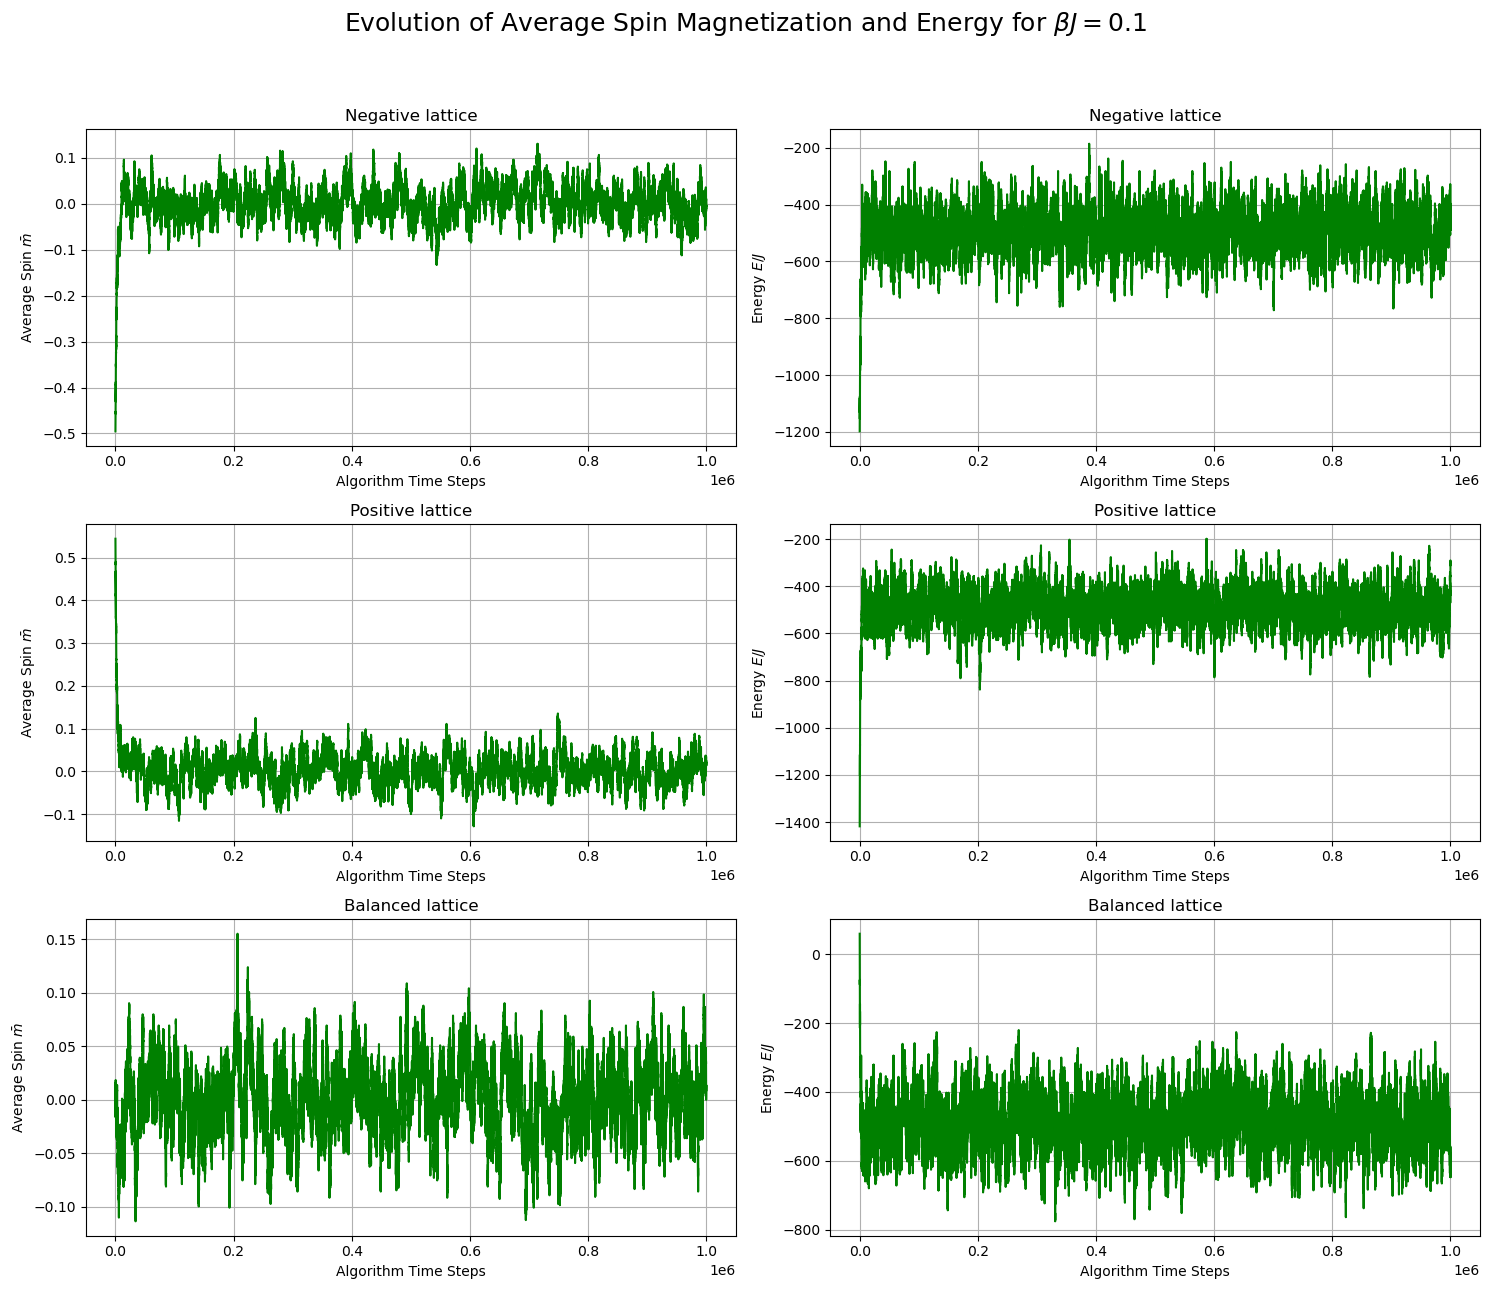

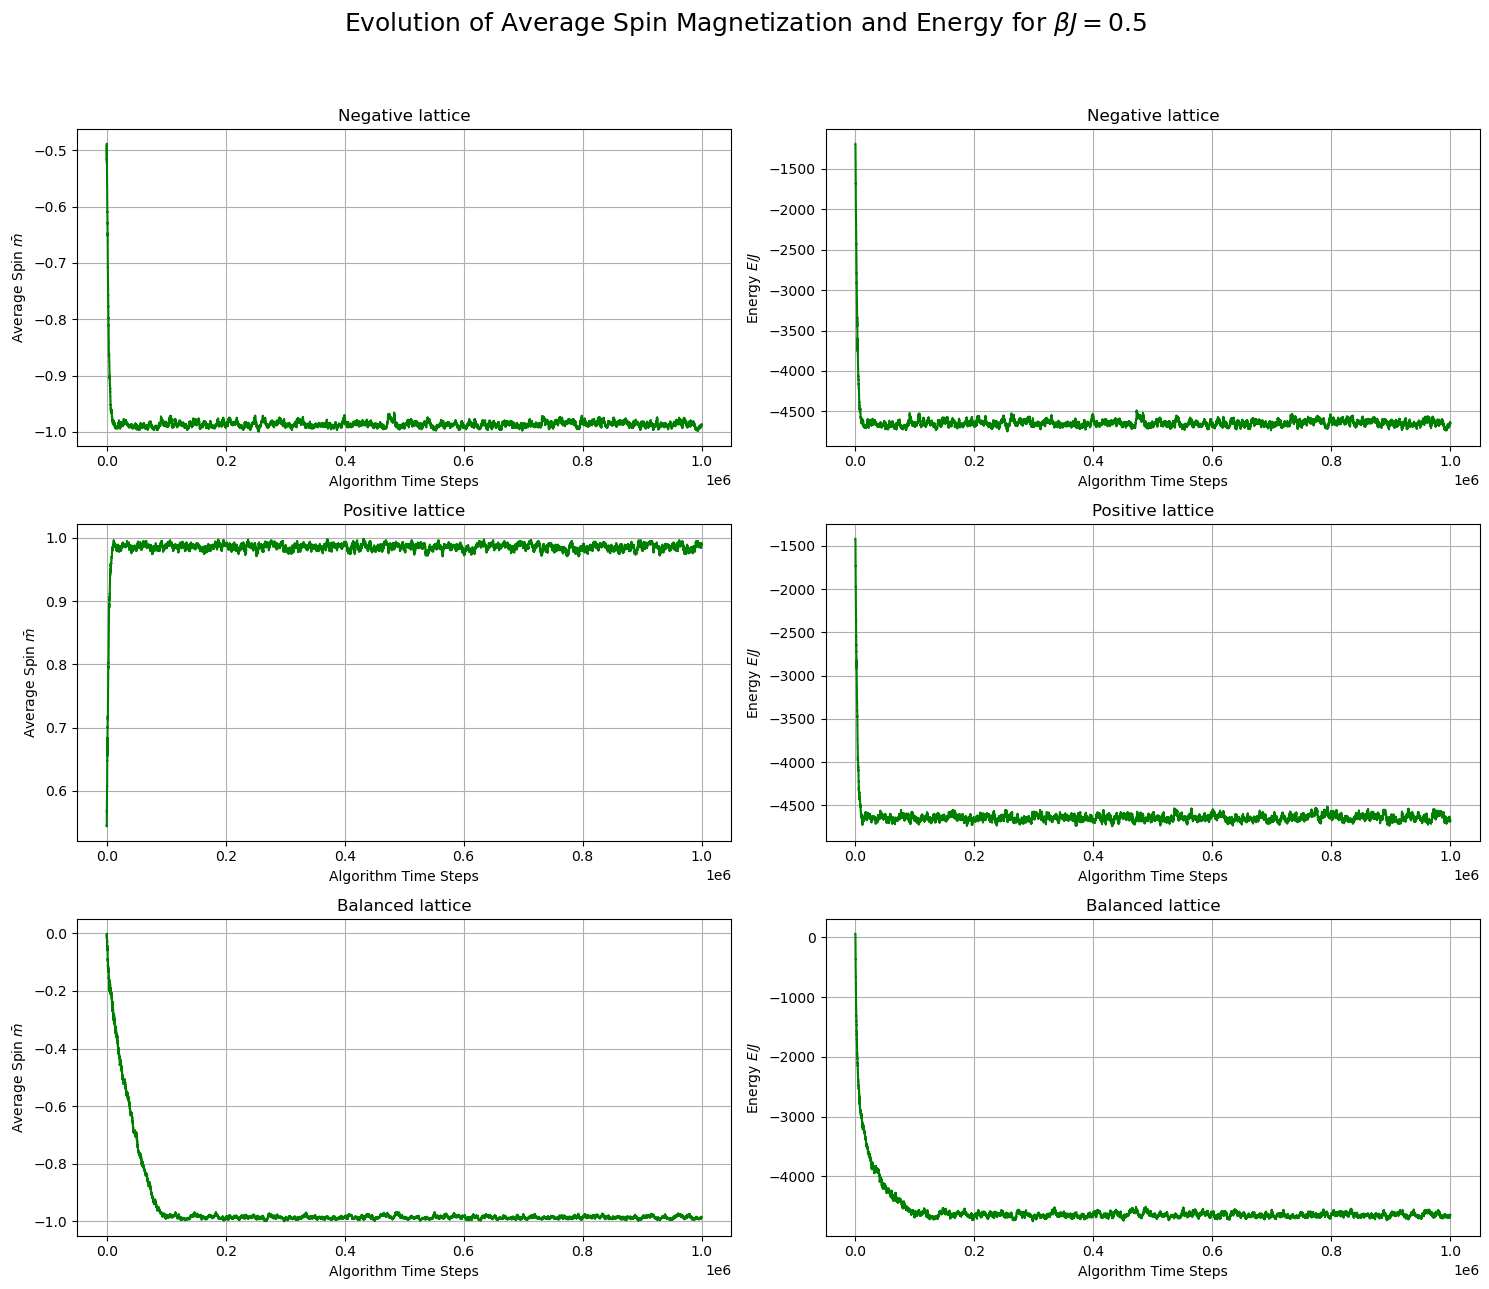

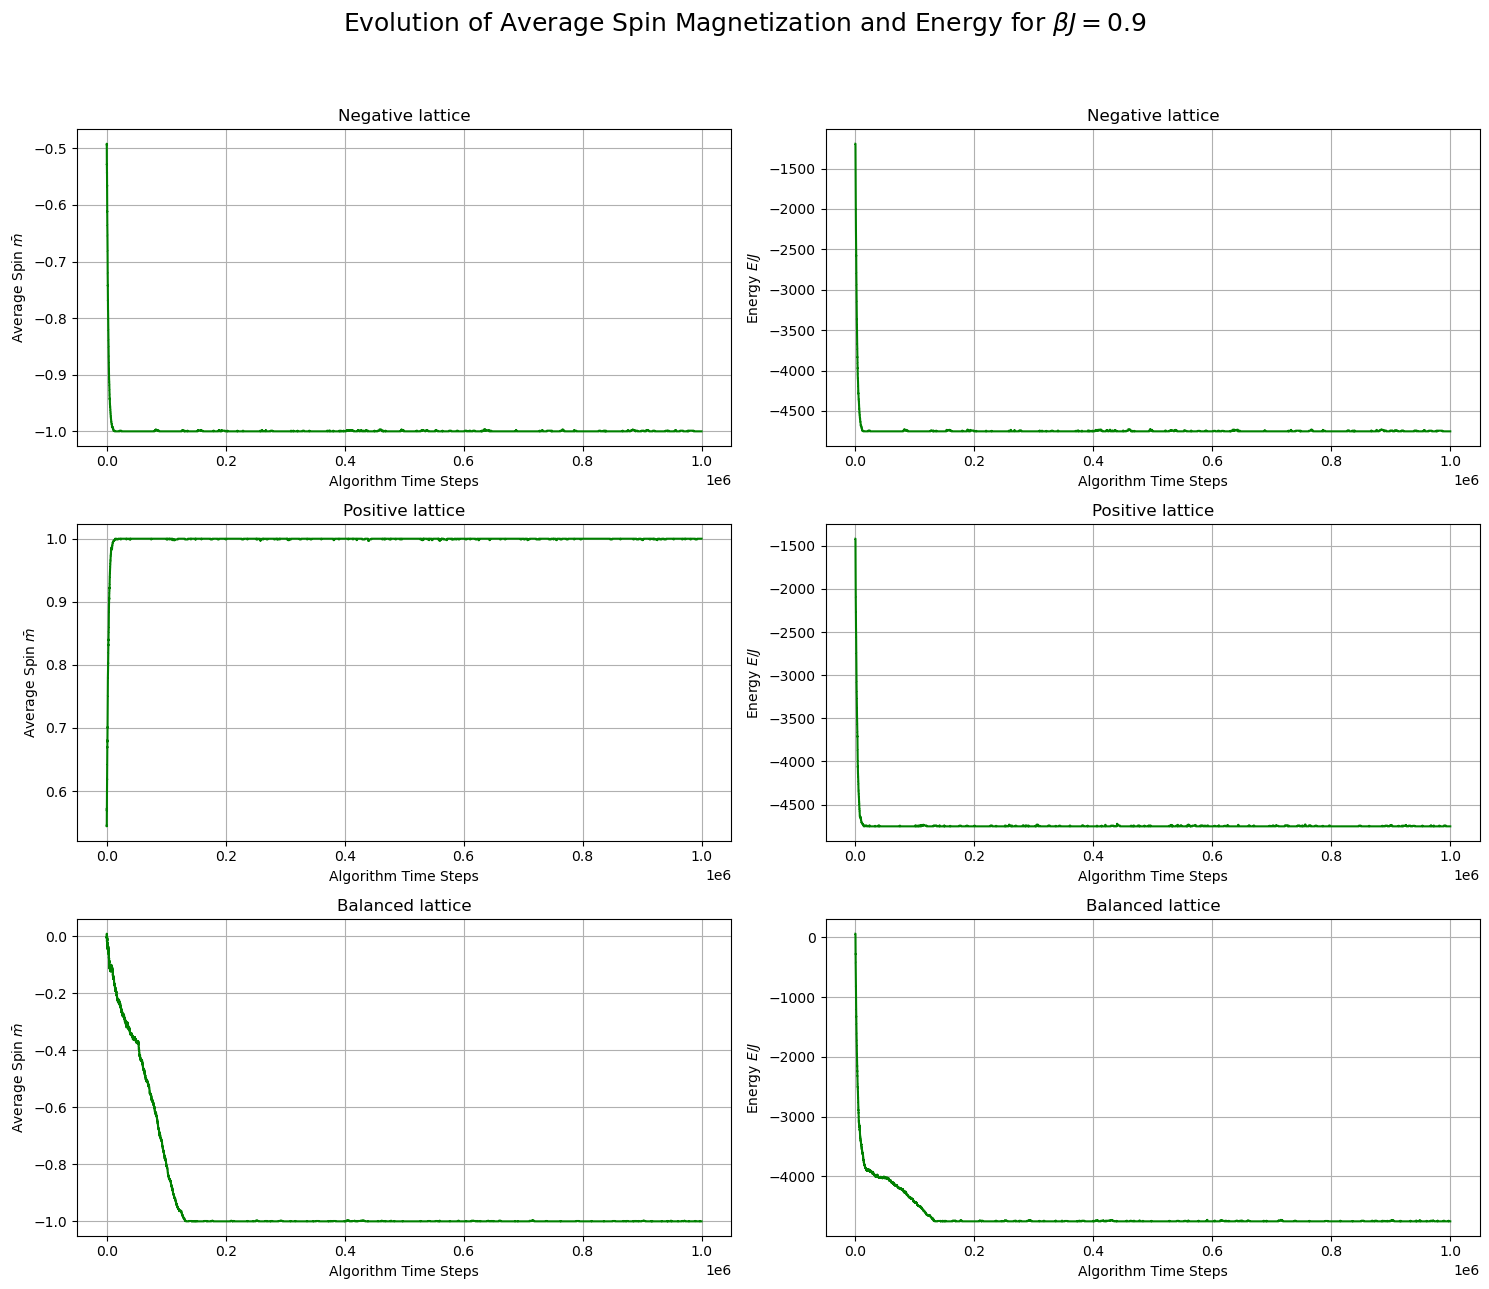

In [42]:
BJ = [0.1, 0.5, 0.9]

for x in BJ:
    spins_n, energies_n = metropolis(lattice_n, N, 10**6, x, get_energy(lattice_n))
    spins_p, energies_p = metropolis(lattice_p, N, 10**6, x, get_energy(lattice_p))
    spins_b, energies_b = metropolis(lattice_b, N, 10**6, x, get_energy(lattice_b))

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    ax = axes[0, 0]
    ax.plot(spins_n/N**3, color = 'green')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Negative lattice")
    ax.grid()
    ax = axes[0, 1]
    ax.plot(energies_n, color = 'green')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Negative lattice")
    ax.grid()

    ax = axes[1, 0]
    ax.plot(spins_p/N**3, color = 'green')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Positive lattice")
    ax.grid()
    ax = axes[1, 1]
    ax.plot(energies_p, color = 'green')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Positive lattice")
    ax.grid()

    ax = axes[2, 0]
    ax.plot(spins_b/N**3, color = 'green')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Balanced lattice")
    ax.grid()
    ax = axes[2, 1]
    ax.plot(energies_b, color = 'green')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Balanced lattice")
    ax.grid()

    fig.tight_layout()
    fig.suptitle(f"Evolution of Average Spin Magnetization and Energy for $\\beta J = {x}$", y=1.07, size=18)
    fig.show()

As we were expecting, convergence occurs faster than before since we reduced the lattice size. \
Similarly to the previous case, the phase transition seems to happen for $ \beta J \in [0.1, 0.5] $ \
In this case, we choose to reduce the bin size to observe the evolution of magnetization. Additionally, we decide not to consider the balanced lattice when examining magnetization as a function of temperature.

In [43]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, BJ in enumerate(BJs):
        spins, energies = metropolis(lattice, N, 10**6, BJ, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**3
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.005)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

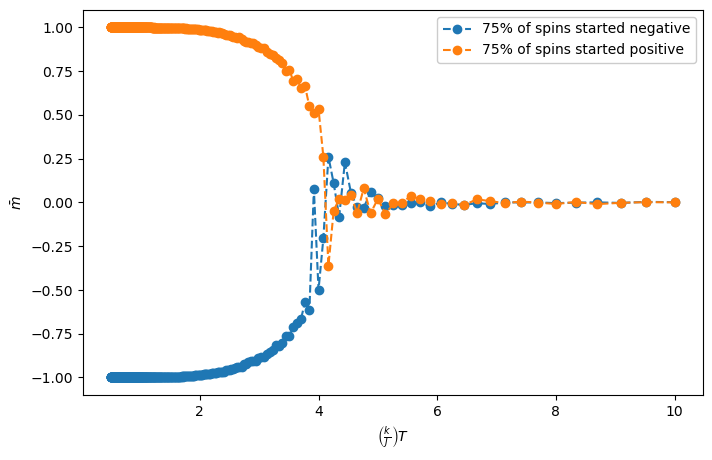

In [44]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [ ]:
critical_idx = max(np.where(abs(ms_n) < 0.025)[0])
critical_BJ = BJs[critical_idx]
critical_T = critical_BJ**(-1)
critical_BJ, critical_T

(0.2100000000000001, 4.761904761904759)

Critical temperature is the same as before. Here we obtain a better estimate of it, given taht we have decreased the bin size.

We now proceed with $N$ = 32.

In [46]:
N = 32

In [47]:
lattice_n, lattice_p, lattice_b = init_lattices(N)

C:\Users\elyel\AppData\Local\Temp\ipykernel_22824\4116872943.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


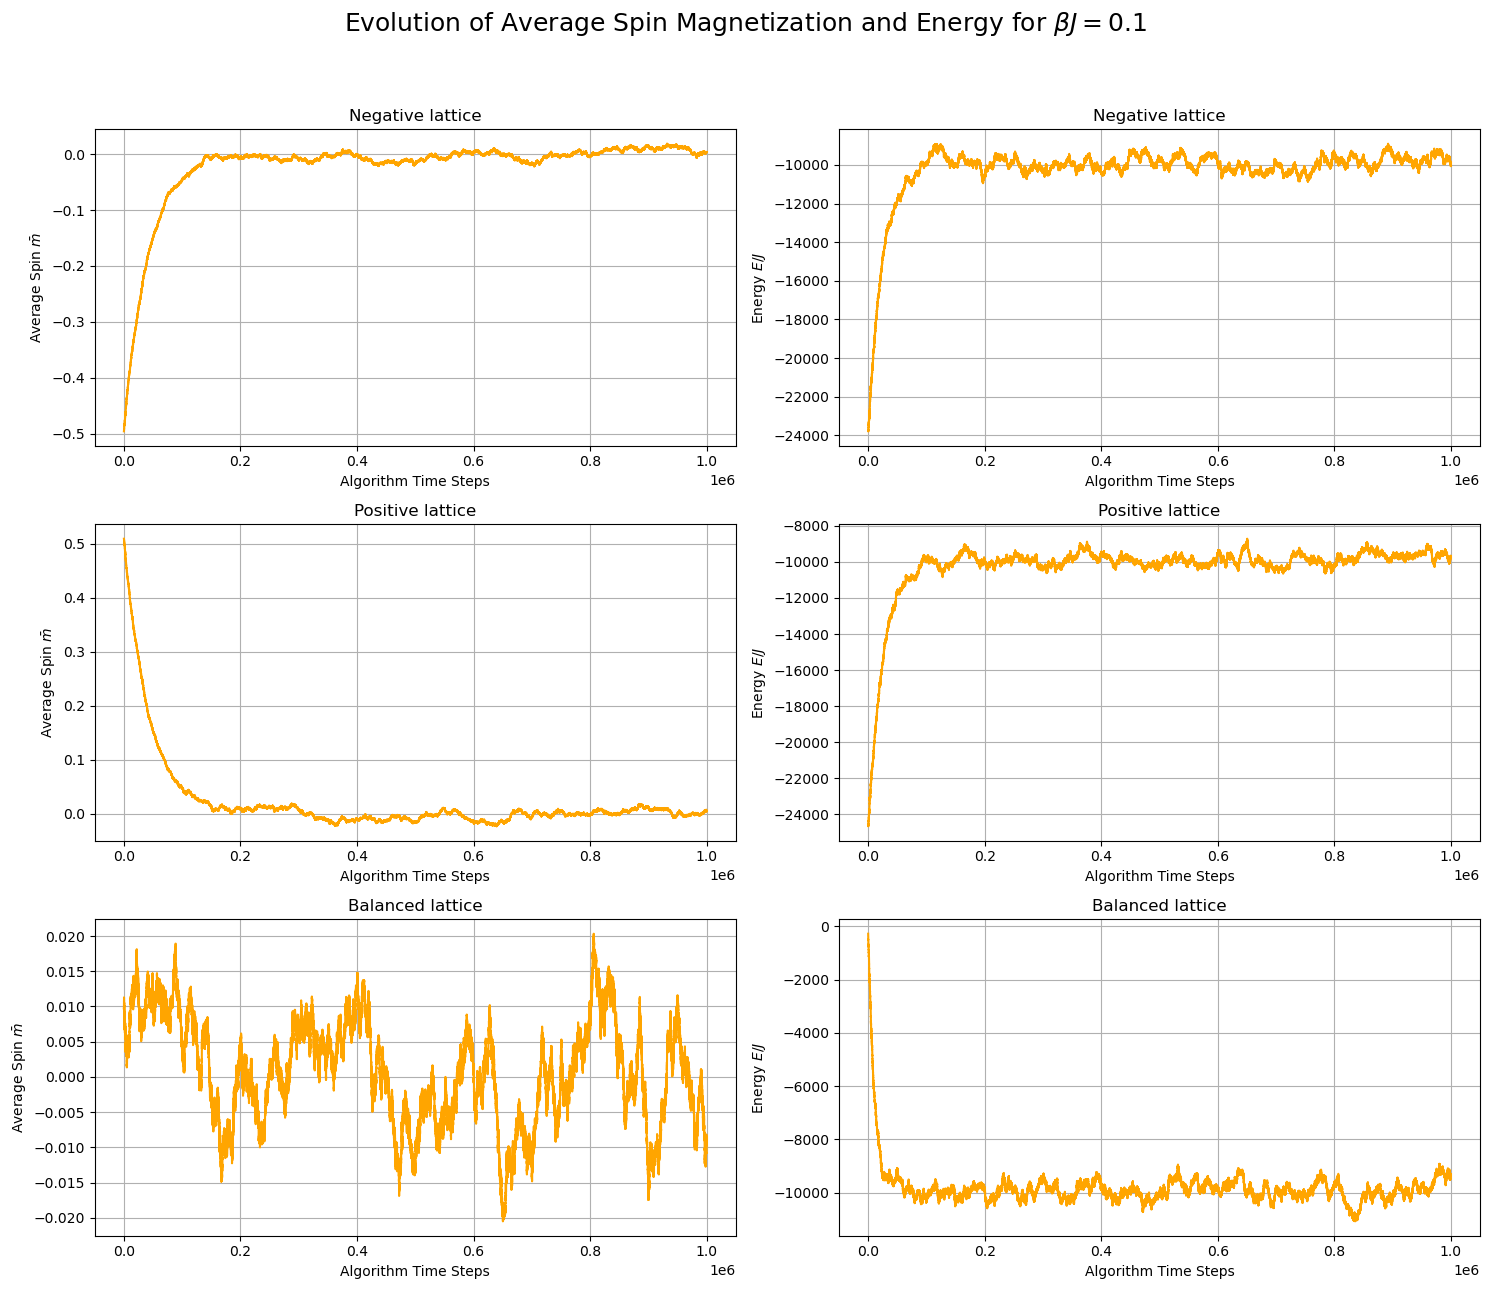

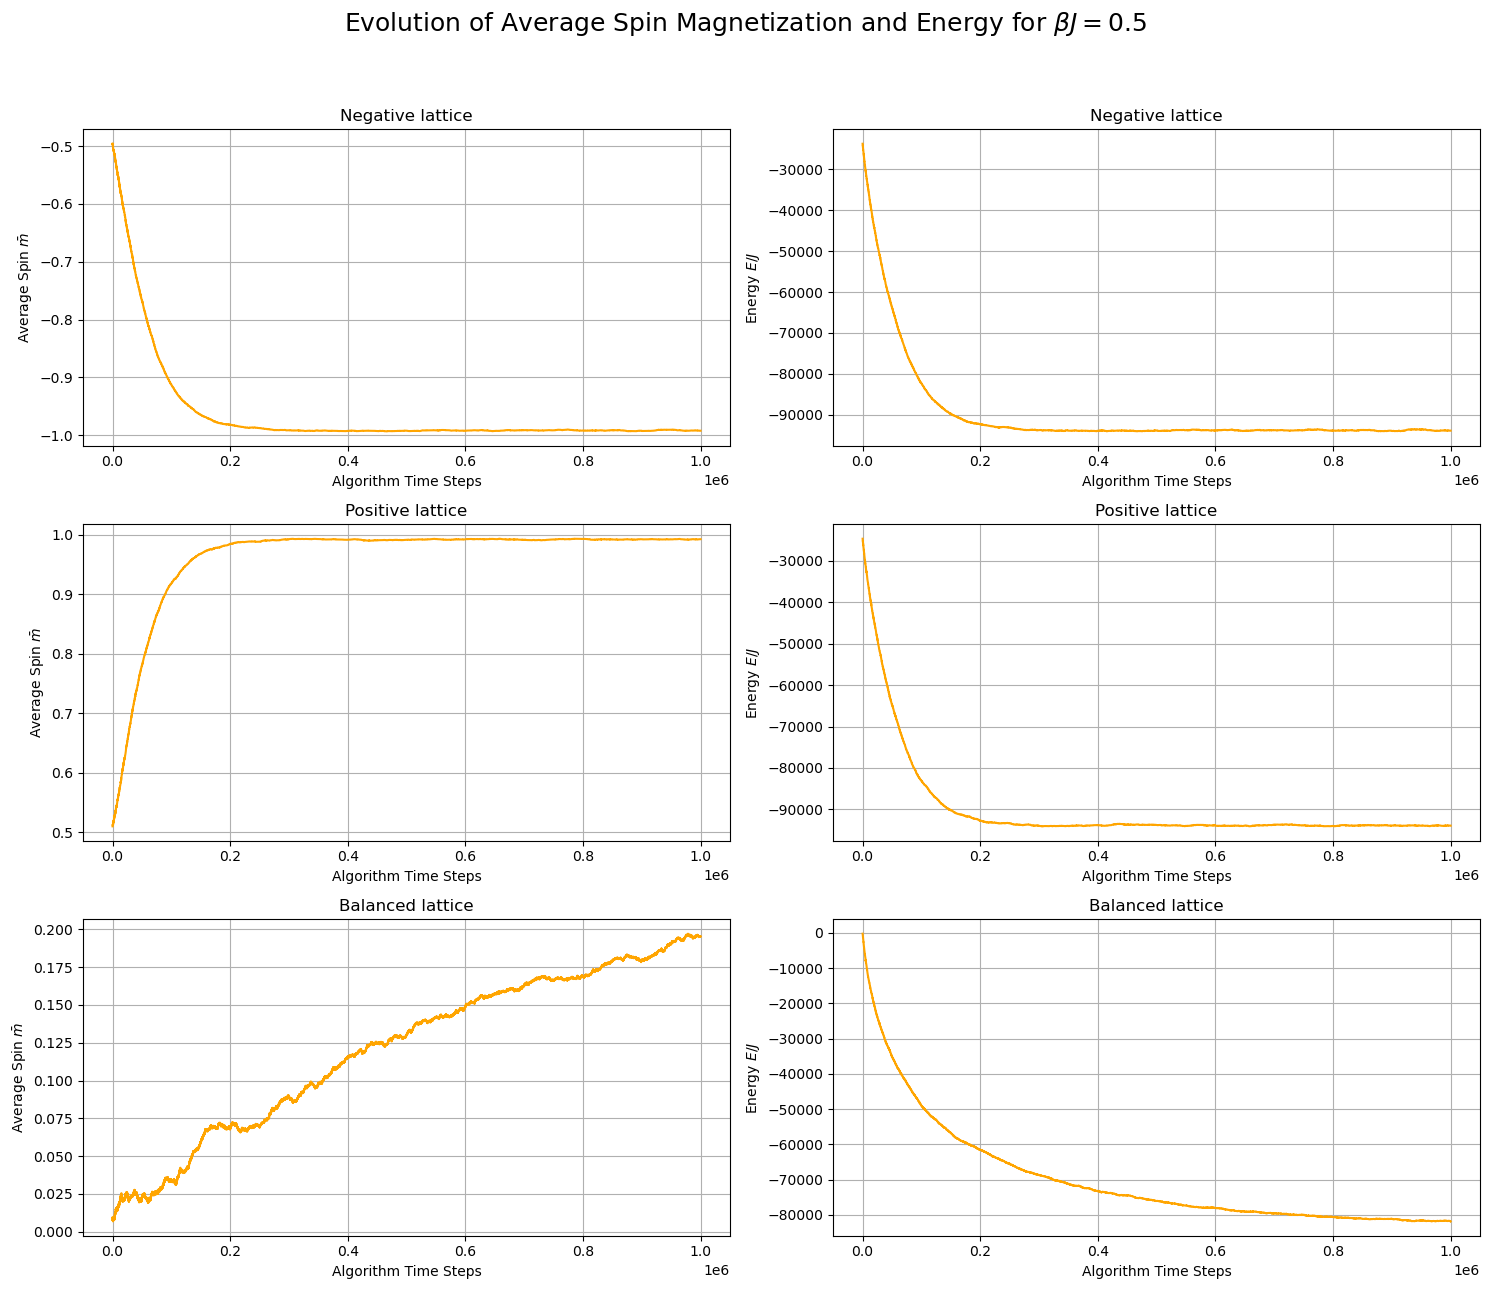

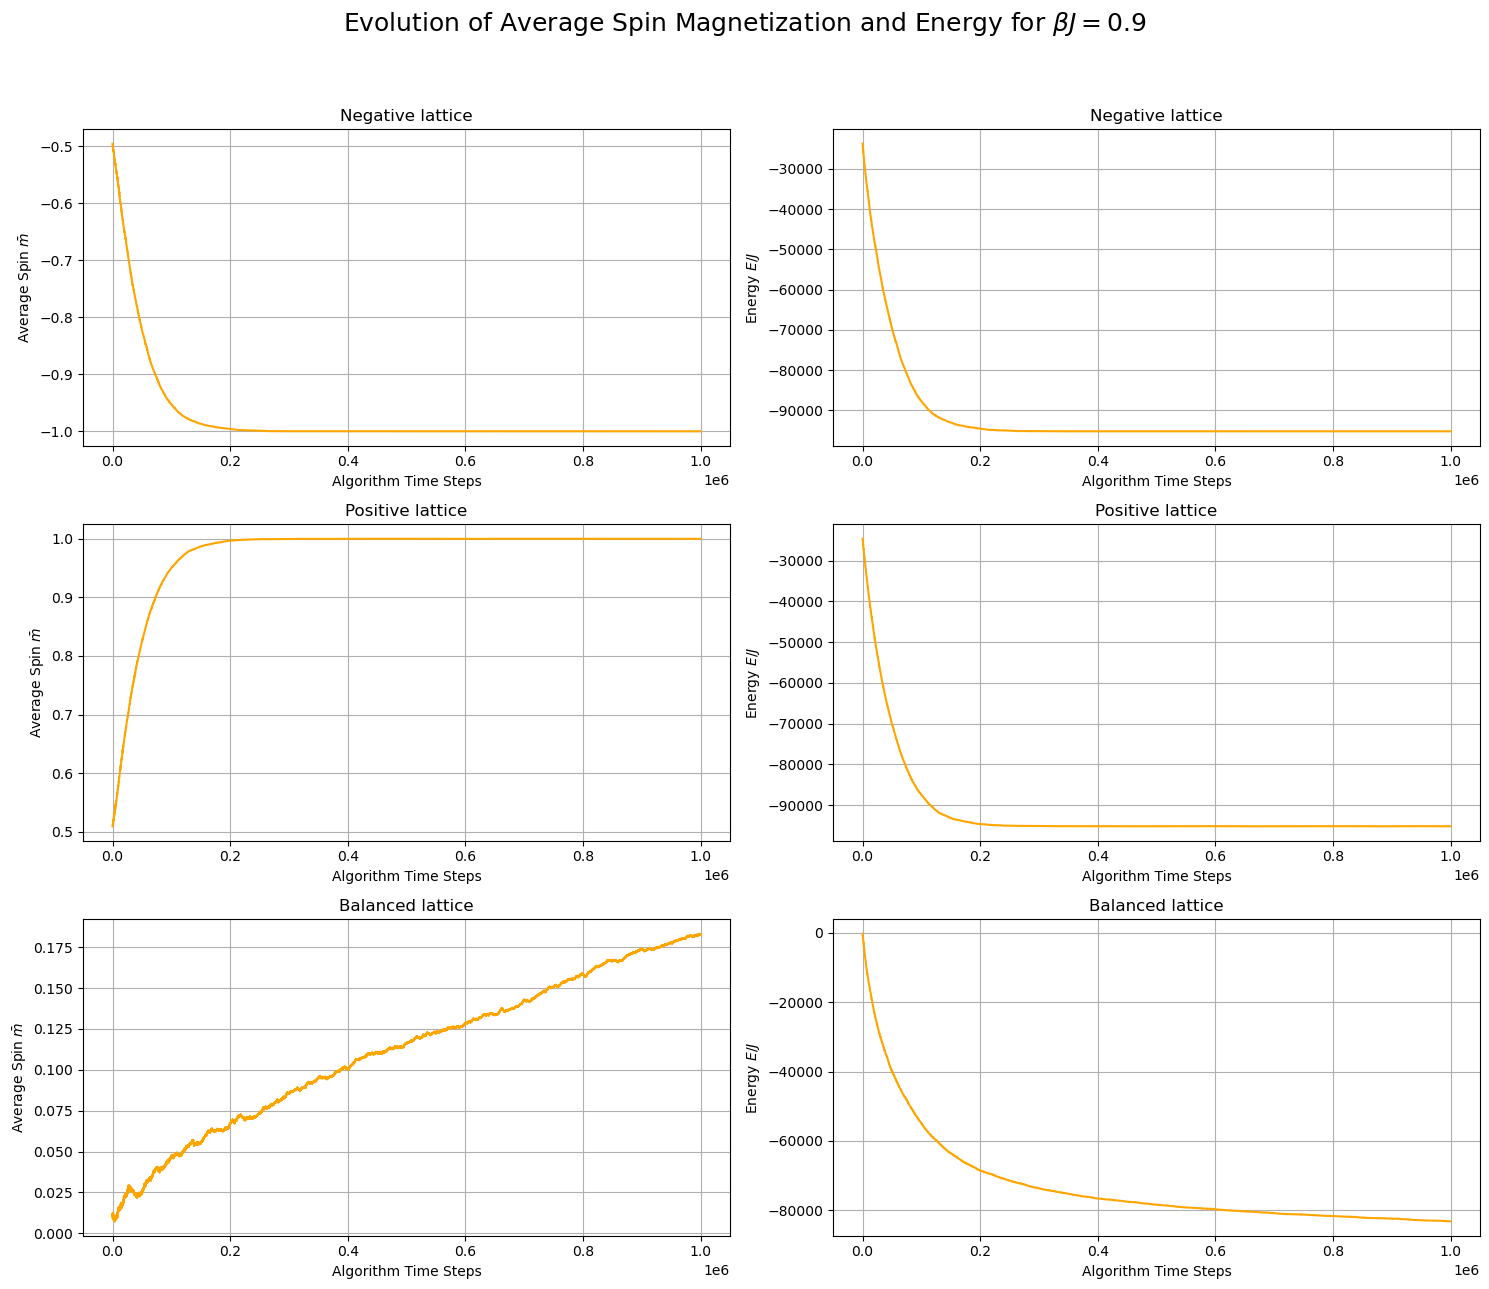

In [48]:
BJ = [0.1, 0.5, 0.9]

for x in BJ:
    spins_n, energies_n = metropolis(lattice_n, N, 10**6, x, get_energy(lattice_n))
    spins_p, energies_p = metropolis(lattice_p, N, 10**6, x, get_energy(lattice_p))
    spins_b, energies_b = metropolis(lattice_b, N, 10**6, x, get_energy(lattice_b))

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    
    ax = axes[0, 0]
    ax.plot(spins_n/N**3, color = 'orange')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Negative lattice")
    ax.grid()
    ax = axes[0, 1]
    ax.plot(energies_n, color = 'orange')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Negative lattice")
    ax.grid()

    ax = axes[1, 0]
    ax.plot(spins_p/N**3, color = 'orange')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Positive lattice")
    ax.grid()
    ax = axes[1, 1]
    ax.plot(energies_p, color = 'orange')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Positive lattice")
    ax.grid()

    ax = axes[2, 0]
    ax.plot(spins_b/N**3, color = 'orange')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Average Spin $\bar{m}$")
    ax.set_title("Balanced lattice")
    ax.grid()
    ax = axes[2, 1]
    ax.plot(energies_b, color = 'orange')
    ax.set_xlabel("Algorithm Time Steps")
    ax.set_ylabel(r"Energy $E/J$")
    ax.set_title("Balanced lattice")
    ax.grid()

    fig.tight_layout()
    fig.suptitle(f"Evolution of Average Spin Magnetization and Energy for $\\beta J = {x}$", y=1.07, size=18)
    fig.show()

Also in this case, convergence to equilibrium configurations is fast for the positive and negative lattice. \
Interestingly, we observe that the speed of convergence of the balanced lattice to a more stable configuration is slower compared to the case of $ N = 12 $.

In [49]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, BJ in enumerate(BJs):
        spins, energies = metropolis(lattice, N, 10**6, BJ, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**3
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.05)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

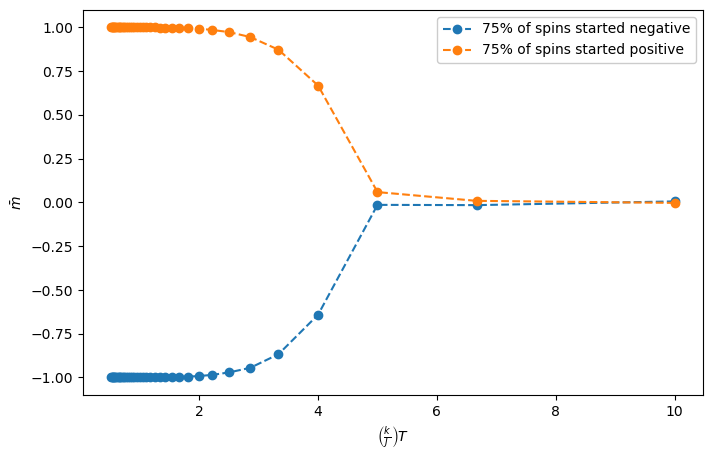

In [50]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

It seems that as we increase $N$, we obtain very similar magnetization diagram as function of temperature. \
Now, we try to estimate the critical temperature precisely in the case in which $N$ is small, to determine if it matches the results obtained so far. \
We consider the case of $N$ = 6, 8, 10

In [ ]:
N = 6

In [ ]:
lattice_n, lattice_p, lattice_b = init_lattices(N)

In [ ]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, BJ in enumerate(BJs):
        spins, energies = metropolis(lattice, N, 10**6, BJ, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**3
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.005)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

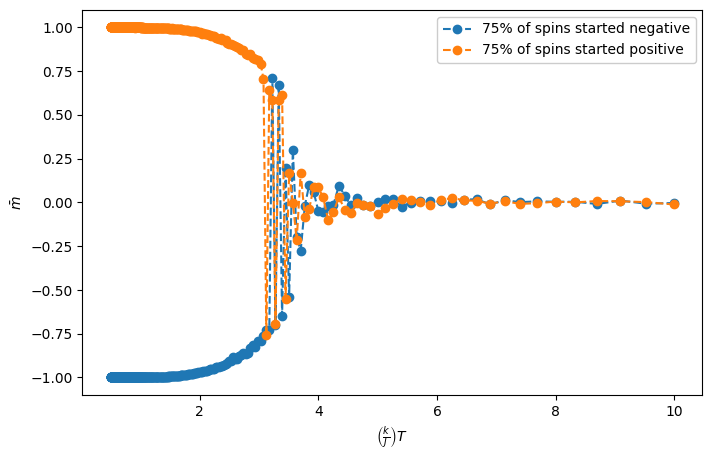

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [ ]:
critical_idx = max(np.where(abs(ms_n) < 0.025)[0])
critical_BJ = BJs[critical_idx]
critical_T = critical_BJ**(-1)
critical_BJ, critical_T

(0.2650000000000001, 3.7735849056603756)

In [51]:
N = 8

In [52]:
lattice_n, lattice_p, lattice_b = init_lattices(N)

In [53]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, BJ in enumerate(BJs):
        spins, energies = metropolis(lattice, N, 10**6, BJ, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**3
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.005)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

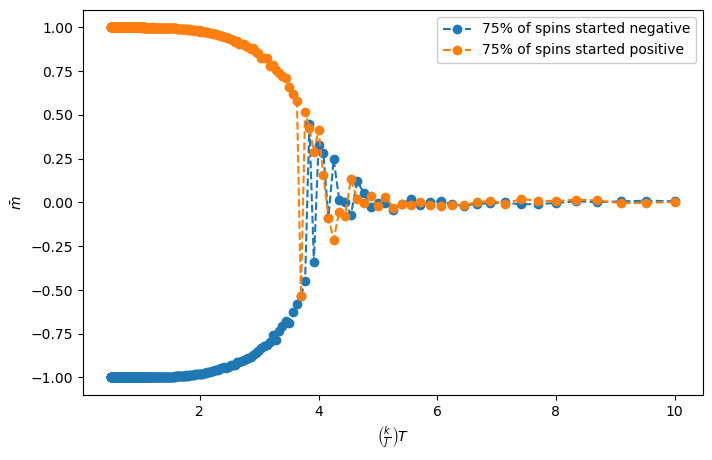

In [54]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [55]:
critical_idx = max(np.where(abs(ms_n) < 0.025)[0])
critical_BJ = BJs[critical_idx]
critical_T = critical_BJ**(-1)
critical_BJ, critical_T

0.23000000000000012 4.34782608695652


In [ ]:
N = 10

In [ ]:
lattice_n, lattice_p, lattice_b = init_lattices(N)

In [ ]:
def get_spin_energy(lattice, BJs):
    ms = np.zeros(len(BJs))
    E_means = np.zeros(len(BJs))
    E_stds = np.zeros(len(BJs))
    for i, BJ in enumerate(BJs):
        spins, energies = metropolis(lattice, N, 10**6, BJ, get_energy(lattice))
        ms[i] = spins[-100000:].mean()/N**3
        E_means[i] = energies[-100000:].mean()
        E_stds[i] = energies[-100000:].std()
    return ms, E_means, E_stds
    
BJs = np.arange(0.1, 2, 0.005)
ms_n, E_means_n, E_stds_n = get_spin_energy(lattice_n, BJs)
ms_p, E_means_p, E_stds_p = get_spin_energy(lattice_p, BJs)

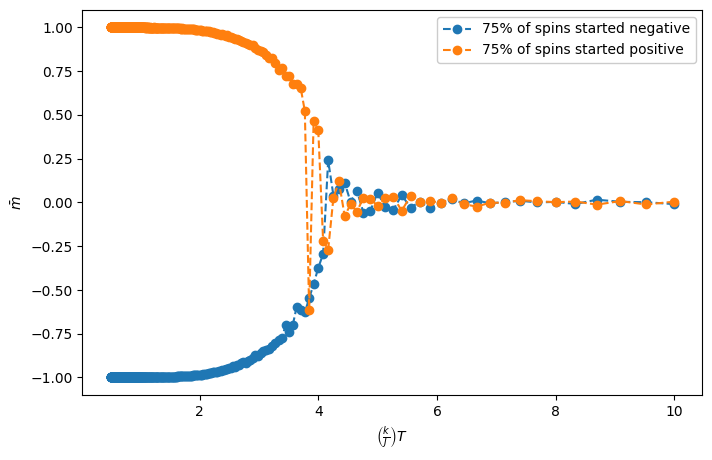

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, ms_n, 'o--', label='75% of spins started negative')
plt.plot(1/BJs, ms_p, 'o--', label='75% of spins started positive')
plt.xlabel(r'$\left(\frac{k}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

In [ ]:
critical_idx = max(np.where(abs(ms_n) < 0.025)[0])
critical_BJ = BJs[critical_idx]
critical_T = critical_BJ**(-1)
critical_BJ, critical_T

(0.2200000000000001, 4.545454545454543)

In all the three cases, we obtain a slightly smaller critical temperature than what we have observed for larger $N$. \
It also seems that when $N$ is small, ($N$ < 10), critical temperature increases as $N$ increases.

### 6. Conclusion

In the 3d Ising model, critical temperature ( $ T \frac{k}{J} $ ) increases slightly as $N$ increases given that $N$ is smaller than 12.
However, further increases in $N$ do not change the critical temperature. Indeed, it stays around 4.7, almost independently of the number of spins $N$. \
In our simulations we got:   $T = 3.8, 4.4, 4.5 $ respectively for  $ N \in \{6, 8, 10 \} $; and $ T \sim 4.7 $ for $ N \in \{12, 20, 32 \} $. \
In the ferromagnetic phase, which corresponds to lower temperature values, configurations that have a high percentage of negative spins move towards an all-negative configuration resulting in an average magnetization of -1. Conversely, configurations with a high number of positive spins move towards an all-positive configuration, leading to an average magnetization of 1. 

Balanced configurations, i.e., systems with a similar ratio of positive and negative spins, converge to either a positive or a negative configuration during the ferromagnetic phase, thereby acquiring a definite magnetization. However, the convergence speed is visibly slowed down as the system size increases.